In [1]:
import glob
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
#import pyfftw
import re

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils
import plotter

%load_ext autoreload
%autoreload 2

2024-09-20 00:38:24.297253: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 00:38:24.536960: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 00:38:24.536999: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 00:38:24.560007: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 00:38:24.633114: I tensorflow/core/platform/cpu_feature_guar

In [2]:
save_plots = False
plot_dir = '../plots/plots_2024-09-17'

## Load and prep emu

In [3]:
# need to modify this on hyperion
dir_emus_lbias = '/home/kstoreyf/external'
emu, emu_bounds, emu_param_names = utils.load_emu(dir_emus_lbias=dir_emus_lbias)
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1 when using ver

Nonlinear l-bias emulator loaded in memory.


/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load lib and p(k)s

In [4]:
# order of saved cosmo param files
# param_names_all = ['omega_cold', 'sigma_8', 'h', 'omega_baryon', 'n_s', 'seed']
# param_names = ['omega_cold', 'sigma_8', 'h']
# param_names_fixed = [name for name in param_names_all if name not in param_names]
# idxs_param_names = [param_names_all.index(name) for name in param_names]

n_grid = 128
n_grid_orig = 512
box_size = 1000.0

#tag_params = '_p3_n500'
tag_params = '_p5_n10000'
tag_mocks = tag_params
tag_fields = '_deconvolved'
#dir_mocks = f'/cosmos_storage/cosmosims/muchisimocks_lib{tag_mocks}'
#dir_mocks = f'/data/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_mocks}'

title_tag = ', b=[1,0,0,0]'
tag_pk = '_b1000'
tag_pk_zspace = '_b1000_zspace'
dir_pks = f'../data/pks_mlib/pks{tag_mocks}{tag_pk}'
dir_pks_zspace = f'../data/pks_mlib/pks{tag_mocks}{tag_pk_zspace}'
bias_params = np.loadtxt(f'{dir_pks}/bias_params.txt')

# idxs_LH = np.sort([int(re.search(r'LH(\d+)', dir_mocks).group(1)) \
#         for dir_mocks in os.listdir(dir_mocks) \
#         if re.search(r'LH\d+', dir_mocks)])
# idxs_LH = np.sort([int(re.search(r'_(\d+)', dir_pks_zspace).group(1)) \
#         for dir_pks_zspace in os.listdir(dir_pks_zspace) \
#         if re.search(r'_\d+', dir_pks_zspace)])

#idxs_LH = np.arange(100)
#idxs_LH = np.arange(1)

fn_params = f'{dir_mocks}/params_lh{tag_params}.txt'
fn_params_fixed = f'{dir_mocks}/params_fixed{tag_params}.txt'
params_df = pd.read_csv(fn_params, index_col=0)
param_dict_fixed = pd.read_csv(fn_params_fixed).loc[0].to_dict()

#idxs_LH = list(params_df.index.values)
# this one gets only ones we've computed pk of (zspace, cuz probs have both if have zspace)
idxs_LH_all = [int(re.search(r'pk_(\d+)\.npy', f).group(1)) for f in glob.glob(f'{dir_pks_zspace}/pk_*.npy')]
idxs_LH_all = np.sort(idxs_LH_all)
# limit to n_plot for now
n_plot = 100
#idxs_LH = idxs_LH_all[:n_plot]
idxs_LH = idxs_LH_all[-n_plot:]

idxs_LH = np.array(idxs_LH)
n_lib = len(idxs_LH)

print(n_lib)

100


In [5]:
print(idxs_LH)

[3857 3858 3859 3861 3868 3869 3870 3871 3872 3873 3874 3875 3876 3877
 3882 3883 3917 3918 3919 3920 3921 3922 3923 3931 3932 3938 3945 3959
 3960 3961 3962 3963 3964 3965 3987 3994 3995 3996 3997 3998 3999 4001
 4002 4003 4004 4005 4008 4009 4010 4011 4012 4013 4014 4015 4016 4017
 4022 4023 4024 4025 4026 4027 4028 4036 4037 4038 4099 4100 4101 4102
 4106 4107 4108 4109 4110 4111 4112 4113 4114 4120 4121 4122 4123 4124
 4125 4126 4127 4128 4134 4135 4136 4137 4138 4141 4142 4143 4148 4149
 4150 4151]


### Load data 

In [6]:
theta = []
Pk = []
Pk_zspace = []
gaussian_error_pk = []
gaussian_error_pk_zspace = []

param_names = params_df.columns.to_list()

for idx_LH in idxs_LH:
    #fn_fields = f'{dir_mocks}/LH{idx_LH}/bias_fields_eul{tag_fields}_{idx_LH}.npy'
    #fn_params = f'{dir_mocks}/LH{idx_LH}/cosmo_{idx_LH}.txt'
    fn_pk = f'{dir_pks}/pk_{idx_LH}.npy'
    fn_pk_zspace = f'{dir_pks_zspace}/pk_{idx_LH}.npy'
    
    pk_obj = np.load(fn_pk, allow_pickle=True).item()
    Pk.append(pk_obj['pk'])
    gaussian_error_pk.append(pk_obj['pk_gaussian_error'])
    
    pk_obj_zspace = np.load(fn_pk_zspace, allow_pickle=True).item()
    Pk_zspace.append(pk_obj_zspace['pk'])
    gaussian_error_pk_zspace.append(pk_obj_zspace['pk_gaussian_error'])
    
    param_dict = params_df.loc[idx_LH].to_dict()
    theta.append( np.array([param_dict[pn] for pn in param_names]) )

Pk = np.array(Pk)
Pk_zspace = np.array(Pk_zspace)
theta = np.array(theta)
gaussian_error_pk = np.array(gaussian_error_pk)

kk = pk_obj['k'] # all ks should be same so just grab one
print(len(kk))
print(Pk.shape)

30
(100, 30)


In [7]:
# overall quantities
Pk_emu = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 100 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    param_dict.update(param_dict_fixed)
    cosmo_params_emu = utils.get_cosmo_emu(param_dict)
    _, pk_model_unscaled, _ = emu.get_galaxy_real_pk(bias=bias_params, k=kk, 
                                                   cold=True, **cosmo_params_emu)
    Pk_emu.append(pk_model_unscaled)
    
Pk_emu = np.array(Pk_emu)
print(Pk_emu.shape)

0
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param tau not in param dict, adding quijote valu

In [8]:
expfactor = 1.0
kaiser_boosts = []
for i, idx_LH in enumerate(idxs_LH):
    if i % 100 == 0:
        print(i)
    param_dict = params_df.loc[idx_LH].to_dict()
    cosmo = utils.get_cosmo(param_dict)
    # kaiser boost only depends on k if neutrino mass is nonzero
    # for kaiser boost, the bias is the linear EULERIAN bias!
    # which is b1_eul = 1 + b1_lag
    bias_eulerian = 1 + bias_params[0]
    kaiser_boosts.append( cosmo.Kaiser_boost(expfactor, l=0, bias=bias_eulerian) )

0
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param wa not in param dict, adding quijote value
Param tau not in param dict, adding quijote value
Param neutrino_mass not in param dict, adding quijote value
Param w0 not in param dict, adding quijote value
Param w

In [9]:
kaiser_boosts = np.array(kaiser_boosts)
Pk_emu_zspace = Pk_emu * kaiser_boosts[:, np.newaxis] 
Pk_kaiserboosted = Pk * kaiser_boosts[:, np.newaxis] 

In [10]:
print(np.min(kaiser_boosts), np.max(kaiser_boosts))

1.1576218654478074 1.2189398993455278


## Plot

/tmp/ipykernel_3424217/1939471527.py:39: RuntimeWarning: divide by zero encountered in divide
  axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3424217/1939471527.py:40: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3424217/1939471527.py:46: RuntimeWarning: divide by zero encountered in divide
  diff_overG = diff_Pk/gaussian_error_pk
/home/kstoreyf/.conda/envs/benv/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_3424217/1939471527.py:51: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7efe6c704c50>, <ErrorbarContainer object of 3 artists>] ['emulated at true $\\theta$', 'map2map measured']
[<matplotlib.lines.Line2D object at 0x7efe6c10d850>, <matplotlib.lines.Line2D object at 0x7efe4c707d90>] ['median', '16-84 percentile']


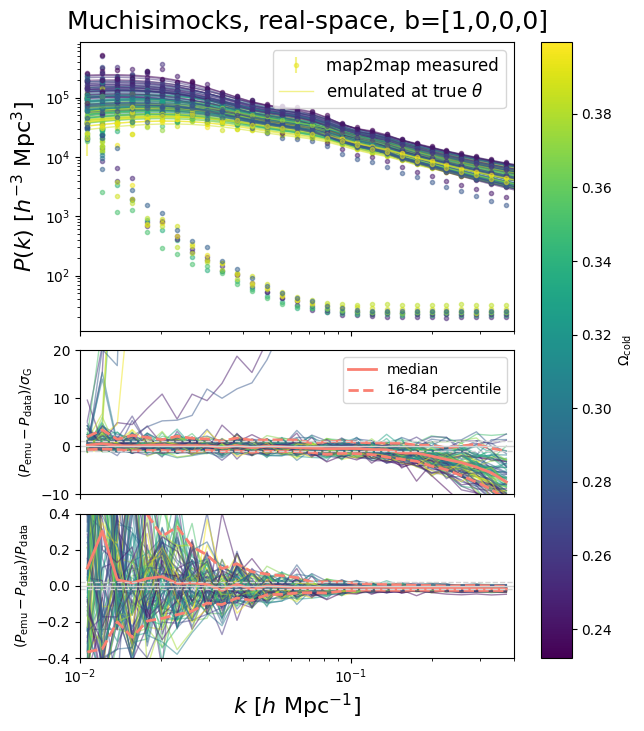

In [11]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, real-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
        
        if first or show_error_all:
            axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk[i], 
                            ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        else:
            axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        axarr[0].plot(k, Pk_emu[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        axarr[1].plot(k, (Pk_emu[i]-Pk[i])/gaussian_error_pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu - Pk
    diff_overG = diff_Pk/gaussian_error_pk
    diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    diff_overG_med = np.median(diff_overG, axis=0)

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overG_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overG_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overG_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(1, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    #axarr[1].set_ylim(-3, 3)
    #axarr[2].set_ylim(-0.1, 0.1)
    axarr[1].set_ylim(-10, 20)
    axarr[2].set_ylim(-0.4, 0.4)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[2].set_ylabel(r'$(P_\text{emu}-P_\text{data})/P_\text{data}$', fontsize=10)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks{tag_pk}.png', bbox_inches='tight')

/tmp/ipykernel_3424217/1192163480.py:46: RuntimeWarning: invalid value encountered in divide
  axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3424217/1192163480.py:47: RuntimeWarning: divide by zero encountered in divide
  axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3424217/1192163480.py:57: RuntimeWarning: divide by zero encountered in divide
  diff_overPk = diff_Pk/Pk_zspace
/tmp/ipykernel_3424217/1192163480.py:67: RuntimeWarning: invalid value encountered in divide
  diff_overPk_realK = diff_Pk_realK/Pk_zspace


[<matplotlib.lines.Line2D object at 0x7efe4c122e90>, <matplotlib.lines.Line2D object at 0x7efe4c142e10>, <matplotlib.lines.Line2D object at 0x7efe4c148290>, <matplotlib.lines.Line2D object at 0x7efe4c148b50>, <matplotlib.lines.Line2D object at 0x7efe4c14abd0>, <matplotlib.lines.Line2D object at 0x7efe4c14b490>, <matplotlib.lines.Line2D object at 0x7efe4c15d690>, <matplotlib.lines.Line2D object at 0x7efe4c15df50>, <matplotlib.lines.Line2D object at 0x7efe4c16c250>, <matplotlib.lines.Line2D object at 0x7efe4c16ca10>, <matplotlib.lines.Line2D object at 0x7efe4c16ebd0>, <matplotlib.lines.Line2D object at 0x7efe4c16f490>, <matplotlib.lines.Line2D object at 0x7efe4c1795d0>, <matplotlib.lines.Line2D object at 0x7efe4c179e10>, <matplotlib.lines.Line2D object at 0x7efe4c17bed0>, <matplotlib.lines.Line2D object at 0x7efe4c184790>, <matplotlib.lines.Line2D object at 0x7efe4c186890>, <matplotlib.lines.Line2D object at 0x7efe4c1870d0>, <matplotlib.lines.Line2D object at 0x7efe4c195110>, <matplotlib

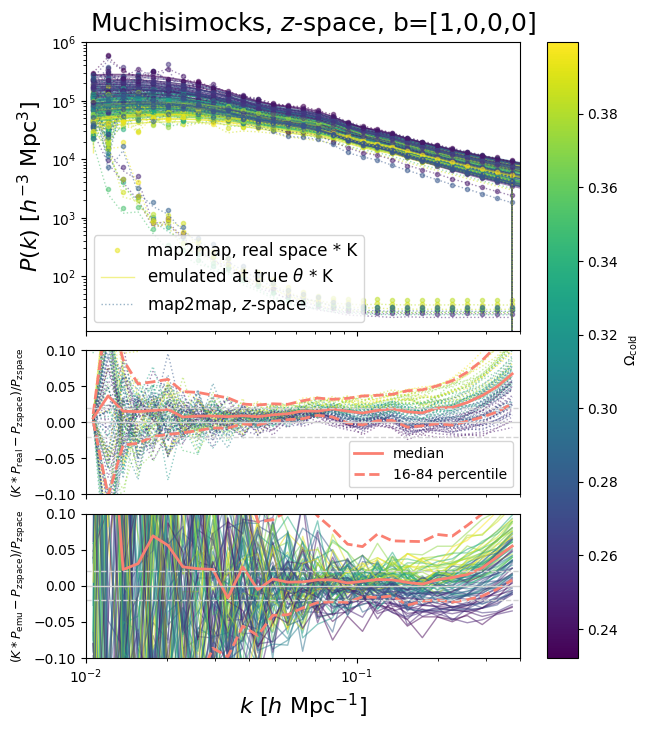

In [12]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 3, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,8), sharex=True, height_ratios=[2,1,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1, ax2 = axarr
    
    fig.suptitle(fr"Muchisimocks, $z$-space{title_tag}", y=0.92, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$ * K'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real_kb = 'map2map, real space * K'
            label_zspace = r'map2map, $z$-space'
            
        if first or show_error_all:
            axarr[0].errorbar(k, Pk_zspace[i], yerr=gaussian_error_pk_zspace[i], 
                            #ls='None', marker='o', markersize=3, alpha=0.5, label=label_zspace, color=colors[i],
                            ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw
                            )
        else:
            #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
            axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        axarr[0].plot(k, Pk_kaiserboosted[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real_kb, color=colors[i])
        axarr[0].plot(k, Pk_emu_zspace[i], ls='-', alpha=0.5, label=label_emu, color=colors[i], lw=lw)

        #axarr[1].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/gaussian_error_pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        axarr[1].plot(k, (Pk_kaiserboosted[i]-Pk_zspace[i])/Pk_zspace[i], ls=':', alpha=0.5, color=colors[i], lw=lw)
        axarr[2].plot(k, (Pk_emu_zspace[i]-Pk_zspace[i])/Pk_zspace[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_emu_zspace - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk = diff_Pk/Pk_zspace
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)
    
    diff_Pk_realK = Pk_kaiserboosted - Pk_zspace
    # diff_overG = diff_Pk/gaussian_error_pk_zspace
    # diff_overG_16 = np.percentile(diff_overG, 16, axis=0)
    # diff_overG_84 = np.percentile(diff_overG, 84, axis=0)
    # diff_overG_med = np.median(diff_overG, axis=0)
    diff_overPk_realK = diff_Pk_realK/Pk_zspace
    diff_overPk_realK_16 = np.percentile(diff_overPk_realK, 16, axis=0)
    diff_overPk_realK_84 = np.percentile(diff_overPk_realK, 84, axis=0)
    diff_overPk_realK_med = np.median(diff_overPk_realK, axis=0)


    alpha_16_84 = 0.5
    axarr[1].plot(k, diff_overPk_realK_med, color='salmon', lw=2, label='median')
    axarr[1].plot(k, diff_overPk_realK_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    axarr[1].plot(k, diff_overPk_realK_84, color='salmon', lw=2, ls='--')
    
    axarr[2].plot(k, diff_overPk_med, color='salmon', lw=2)
    axarr[2].plot(k, diff_overPk_16, color='salmon', lw=2, ls='--')
    axarr[2].plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    axarr[1].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[1].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(-0.02, color='lightgrey', lw=1, ls=ls_1sig)
    axarr[2].axhline(0.02, color='lightgrey', lw=1, ls=ls_1sig)
    # axarr[1].fill_between(k, diff_overG_16, diff_overG_84, color='salmon', alpha=alpha_16_84,
    #                       zorder=10000,
    #                     label='16-84 percentile of training set')
    # axarr[2].fill_between(k, diff_overPk_16, diff_overPk_84, color='salmon', zorder=10000, alpha=alpha_16_84)
    # axarr[3].fill_between(k, ratio_16, ratio_84, color='salmon', zorder=10000, alpha=alpha_16_84)
           
    color_hline = 'lightgrey'
    axarr[1].axhline(0, color=color_hline, lw=1)
    axarr[2].axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.1, 0.1)
    axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [0,1,2]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)

    axarr[1].legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    #axarr[1].set_ylabel(r'$(P_\text{emu}-P_\text{data})/\sigma_\text{G}$', fontsize=10)
    axarr[1].set_ylabel(r'$(K*P_\text{real}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)
    axarr[2].set_ylabel(r'$(K*P_\text{emu}-P_\text{zspace})/P_\text{zspace}$', fontsize=9)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_zspace{tag_pk_zspace}.png', bbox_inches='tight')

/tmp/ipykernel_3424217/2375682257.py:45: RuntimeWarning: invalid value encountered in divide
  ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
/tmp/ipykernel_3424217/2375682257.py:52: RuntimeWarning: invalid value encountered in divide
  diff_overPk = diff_Pk/Pk


[<matplotlib.lines.Line2D object at 0x7efe0c6341d0>, <matplotlib.lines.Line2D object at 0x7efe0c7e1410>] ['map2map, real space', 'map2map, $z$-space']
[<matplotlib.lines.Line2D object at 0x7efe2c19f7d0>, <matplotlib.lines.Line2D object at 0x7efe0c4c3690>] ['median', '16-84 percentile']


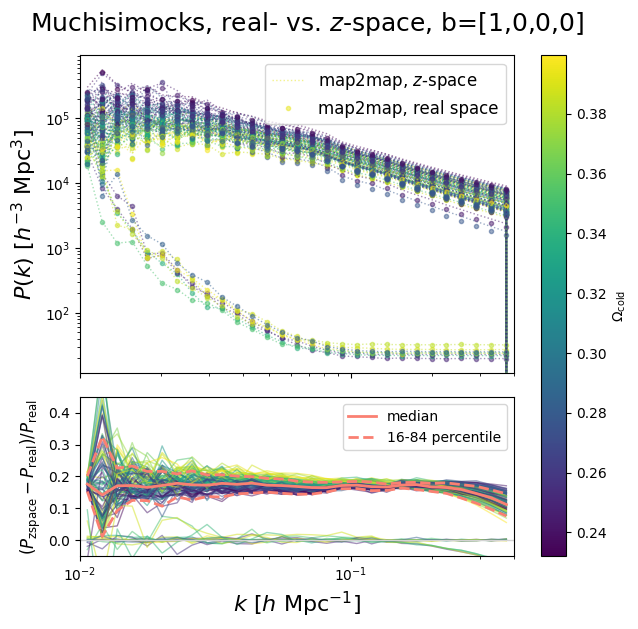

In [13]:
#for pp, param_name_compare in enumerate(param_names):
for pp, param_name_compare in enumerate(param_names[:1]):

    idx_param = param_names.index(param_name_compare)
    param_vals = np.array([theta[i][idx_param] for i in range(n_lib)])
    
    normalizer = mpl.colors.Normalize(vmin=np.min(param_vals), vmax=np.max(param_vals))
    sm = mpl.cm.ScalarMappable(norm=normalizer, cmap=mpl.cm.viridis)#.to_rgba(cvals)
    colors = sm.to_rgba(param_vals)
    
    nrows, ncols = 2, 1
    fig, axarr = plt.subplots(nrows, ncols, figsize=(7,6.5), sharex=True, height_ratios=[2,1])
    plt.subplots_adjust(hspace=0.1)
    ax, ax1 = axarr
    
    fig.suptitle(fr"Muchisimocks, real- vs. $z$-space{title_tag}", y=0.95, x=0.45, fontsize=18)

    lw = 1
    show_error_all = False
    first = True

    k = kk
    for i in range(n_plot):
        
        label_true, label_emu, label_stdev = None, None, None
        label_real, label_zspace = None, None
        if first:
            label_true = 'map2map measured'
            label_emu = r'emulated at true $\theta$'
            label_stdev = r'$0.2*\sigma_\text{stdev}(P_\text{train}(k))$'
            label_real = 'map2map, real space'
            label_zspace = r'map2map, $z$-space'
        
        #axarr[0].plot(k, Pk[i], ls='--', alpha=0.5, label=label_real, color=colors[i], lw=lw)
        axarr[0].plot(k, Pk[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_real, color=colors[i])
        #axarr[0].plot(k, Pk_zspace[i], ls='None', marker='d', markersize=3, alpha=0.5, label=label_zspace, color=colors[i], markerfacecolor='None')
        axarr[0].plot(k, Pk_zspace[i], ls=':', alpha=0.5, label=label_zspace, color=colors[i], lw=lw)

        # if first or show_error_all:
        #     axarr[0].errorbar(k, Pk[i], yerr=gaussian_error_pk_zspace[i], 
        #                     ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        # else:
        #     axarr[0].plot(k, Pk_zspace[i], ls='None', marker='o', markersize=3, alpha=0.5, label=label_true, color=colors[i])
        
        ax1.plot(k, (Pk_zspace[i]-Pk[i])/Pk[i], ls='-', alpha=0.5, color=colors[i], lw=lw)
        
        first = False
        
    # whole set 16-84
    diff_Pk = Pk_zspace - Pk

    diff_overPk = diff_Pk/Pk
    diff_overPk_16 = np.percentile(diff_overPk, 16, axis=0)
    diff_overPk_84 = np.percentile(diff_overPk, 84, axis=0)
    diff_overPk_med = np.median(diff_overPk, axis=0)

    alpha_16_84 = 0.5

    ax1.plot(k, diff_overPk_med, color='salmon', lw=2, label='median')
    ax1.plot(k, diff_overPk_16, color='salmon', lw=2, ls='--', label='16-84 percentile')
    ax1.plot(k, diff_overPk_84, color='salmon', lw=2, ls='--')

    ls_1sig='--'
    color_hline = 'lightgrey'
    ax1.axhline(0, color=color_hline, lw=1)

    # plot settings
    plt.xscale('log')
    axarr[0].set_yscale('log')
        
    plt.xlim(1e-2, 0.4)
    #axarr[0].set_ylim(1e3, 5e5)
    #axarr[0].set_ylim(1e2, 2e5)

    axarr[1].set_ylim(-0.05, 0.45)
    #axarr[2].set_ylim(-0.1, 0.1)
        
    handles, labels = axarr[0].get_legend_handles_labels()
    print(handles, labels)
    #order = [1,0,2]
    order = [1,0]
    axarr[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=12)
    # axarr[0].legend(fontsize=12)
    handles, labels = axarr[1].get_legend_handles_labels()
    print(handles, labels)
    #axarr[1].legend(fontsize=10)

    ax1.legend(fontsize=10)

    axarr[-1].set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$', fontsize=16)
    axarr[0].set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$', fontsize=16)    
    ax1.set_ylabel(r'$(P_\text{zspace}-P_\text{real})/P_\text{real}$', fontsize=12)

    cbar = plt.colorbar(sm, ax=axarr.ravel().tolist())
    cbar.set_label(utils.param_label_dict[param_name_compare])
    
if save_plots:
    plt.savefig(f'{plot_dir}/muchisimocks_vszspace{tag_pk}.png', bbox_inches='tight')

## Check effect of tau

In [137]:
idx_LH_check = 0


In [138]:
param_dict = params_df.loc[idx_LH].to_dict()
param_dict.update(param_dict_fixed)
cosmo = utils.get_cosmo(param_dict, a_scale=expfactor, sim_name='quijote')

## Start cosmology class
expfactor = 1.0
seed = idx_LH_check
sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid, Seed=seed,
                                                    FixedInitialAmplitude=False, InitialPhase=0, 
                                                    expfactor=expfactor, LPT_order=1, order_by_order=None,
                                                    phase_type=1, ngenic_phases=True, return_disp=True, 
                                                    sphere_mode=0)

param_dict_taufix = param_dict.copy()
param_dict_taufix['tau'] = 0.0925 # raul used 0.0952, but planck 2018 is 0.0925 - typo or diff val?
cosmo_quijote_taufix = utils.get_cosmo(param_dict_taufix)

sim_taufix, disp_field_taufix = bacco.utils.create_lpt_simulation(cosmo_quijote_taufix, box_size, Nmesh=n_grid, Seed=seed,
                                                FixedInitialAmplitude=False, InitialPhase=0, 
                                                expfactor=expfactor, LPT_order=1, order_by_order=None,
                                                phase_type=1, ngenic_phases=True, return_disp=True, 
                                                sphere_mode=0)

Param tau not in param dict, adding quijote value


2024-09-20 01:12:47,178 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 01:12:47,178 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 01:12:47,179 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 01:12:47,179 bacco.sims : ...done in 0.000744 s
INFO:bacco.sims:...done in 0.000744 s
2024-09-20 01:12:48,262 bacco.scaler : Adding displacement field with a vel-factor=46.121736
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.121736


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.121736 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 01:12:49,832 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 01:12:49,833 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 01:12:49,834 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 01:12:49,834 bacco.sims : ...done in 0.000756 s
INFO:bacco.sims:...done in 0.000756 s
2024-09-20 01:12:51,166 bacco.scaler : Adding displacement field with a vel-factor=46.121736
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.121736


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.121736 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [139]:
np.allclose(disp_field, disp_field_taufix)

True

In [140]:
np.allclose(sim.linear_field[0], sim_taufix.linear_field[0])

2024-09-20 01:12:53,083 bacco.sims : Generating linear field: Di=1.0
INFO:bacco.sims:Generating linear field: Di=1.0
2024-09-20 01:12:53,380 bacco.sims : Generating linear field: Di=1.0


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


INFO:bacco.sims:Generating linear field: Di=1.0


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =0 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =0 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


True

In [141]:
np.allclose(sim.sdm['vel'], sim_taufix.sdm['vel'])

True

In [142]:
# cosmo is also passed to bacco.statistics.compute_zsd, but only the hubble factor and expansion factor are used

## Check against lpt sim (for race condition issue)

TODO don't forget to check zspace too

In [143]:
# idx_LH_check_2 = idxs_LH[10]
idx_LH_check_2 = 15
print(idx_LH_check, idx_LH_check_2)

0 15


In [144]:
idx_LH = idx_LH_check
dir_LH = f'{dir_mocks}/LH{idx_LH}'

fn_bfields_kcut_deconvolved = f'{dir_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
tag_zspace = '_zspace'
fn_bfields_zspace_kcut_deconvolved = f'{dir_LH}/bias_fields_eul{tag_zspace}_deconvolved_{idx_LH}.npy'
print(fn_bfields_kcut_deconvolved)
bias_terms_eul_pred_kcut_deconvolved = np.load(fn_bfields_kcut_deconvolved)
bias_terms_eul_pred_zspace_kcut_deconvolved = np.load(fn_bfields_zspace_kcut_deconvolved)

/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH0/bias_fields_eul_deconvolved_0.npy


In [145]:
idx_LH = idx_LH_check_2
dir_LH = f'{dir_mocks}/LH{idx_LH}'

fn_bfields_kcut_deconvolved = f'{dir_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
tag_zspace = '_zspace'
fn_bfields_zspace_kcut_deconvolved = f'{dir_LH}/bias_fields_eul{tag_zspace}_deconvolved_{idx_LH}.npy'
print(fn_bfields_kcut_deconvolved)
bias_terms_eul_pred_kcut_deconvolved_2 = np.load(fn_bfields_kcut_deconvolved)
bias_terms_eul_pred_zspace_kcut_deconvolved_2 = np.load(fn_bfields_zspace_kcut_deconvolved)

/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH15/bias_fields_eul_deconvolved_15.npy


In [146]:
np.allclose(bias_terms_eul_pred_kcut_deconvolved, bias_terms_eul_pred_kcut_deconvolved_2)

False

In [147]:
print(bias_terms_eul_pred_kcut_deconvolved[0,0,0,:5], bias_terms_eul_pred_kcut_deconvolved_2[0,0,0,:5])

[29.024109   0.7798425 22.629606  81.558136  82.3506   ] [ 56.761948   20.555573  -20.841087   27.806635   10.2333145]


In [148]:
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)

pos_ZA = bacco.scaler.add_displacement(None,
                                    disp_field,
                                    box=box_size,
                                    #pos=grid.reshape(-1,3),
                                    pos=grid.reshape(-1,3),
                                    vel=None,
                                    vel_factor=0,
                                    verbose=True)[0]

2024-09-20 01:12:59,409 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [149]:
pos_ZA_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_ZA, 
                                         deposit_method='cic', interlacing=False)[0]

2024-09-20 01:12:59,792 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 01:12:59,793 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 01:12:59,805 bacco.statistics :  mesh done in 0.0126 s
INFO:bacco.statistics: mesh done in 0.0126 s


bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


In [150]:
print(np.mean(pos_ZA_mesh), np.std(pos_ZA_mesh))
print(np.mean(bias_terms_eul_pred_kcut_deconvolved[0]), np.std(bias_terms_eul_pred_kcut_deconvolved[0]))

0.9999998 0.90403926
64.00001 86.057556


0.0 18.516022
0.0 18.516022
(128, 128, 128)
(128, 128)


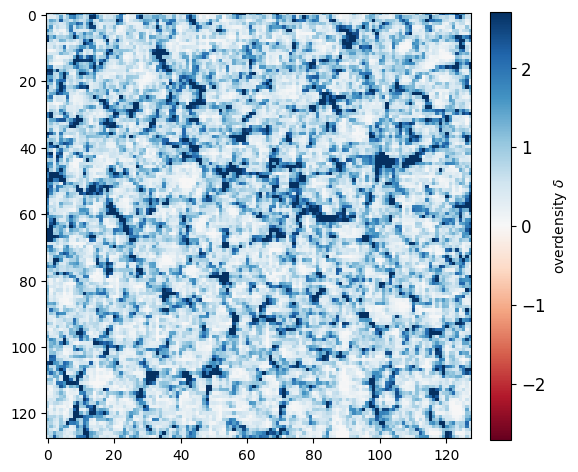

In [151]:
plotter.plot_field(pos_ZA_mesh)


-946.83813 4554.8994
-946.83813 4554.8994
(128, 128, 128)
(128, 128)


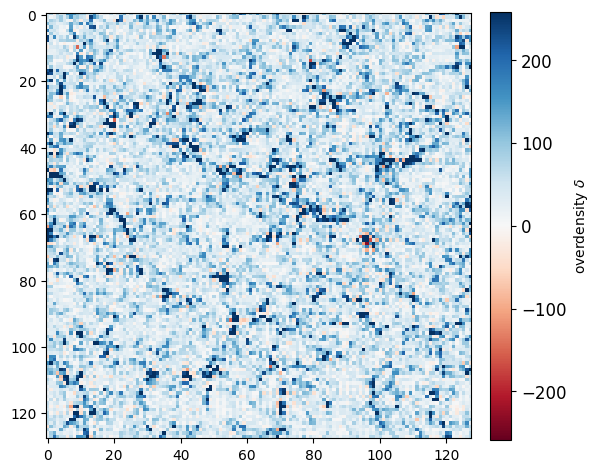

In [152]:
plotter.plot_field(bias_terms_eul_pred_kcut_deconvolved[0])

-716.9003 4781.066
-716.9003 4781.066
(128, 128, 128)
(128, 128)


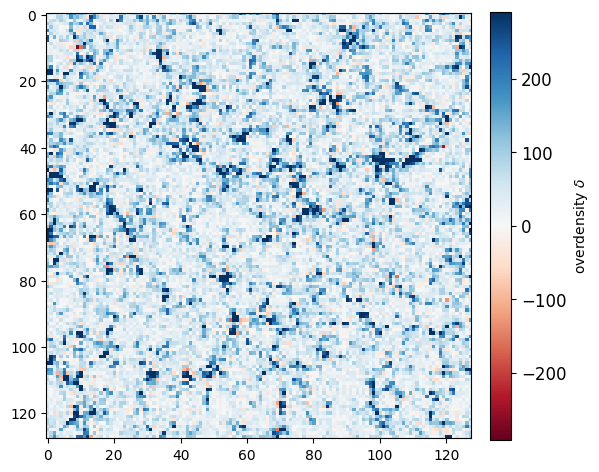

In [153]:
plotter.plot_field(bias_terms_eul_pred_zspace_kcut_deconvolved[0])

mean std 2.0369043e-07 0.99999994
-1.1061465 19.375288
-1.1061465 19.375288
(128, 128, 128)
(128, 128)


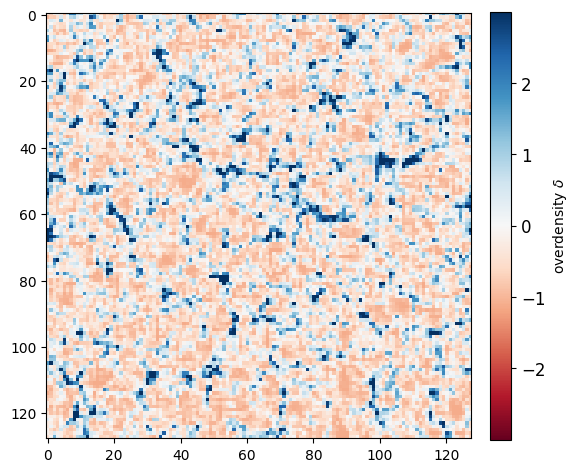

In [154]:
pos_ZA_mesh_normed = (pos_ZA_mesh - np.mean(pos_ZA_mesh))/np.std(pos_ZA_mesh)
print("mean std", np.mean(pos_ZA_mesh_normed), np.std(pos_ZA_mesh_normed))
plotter.plot_field(pos_ZA_mesh_normed)


mean std -9.154246e-08 1.0
-11.746071 52.184837
-11.746071 52.184837
(128, 128, 128)
(128, 128)


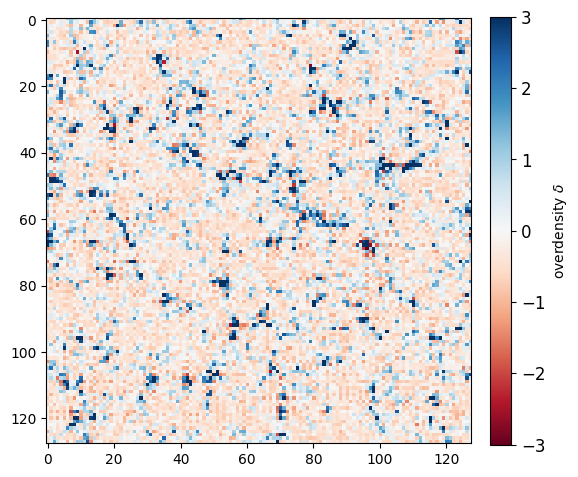

In [155]:
bias0 = bias_terms_eul_pred_kcut_deconvolved[0]
bias0_normed = (bias0 - np.mean(bias0))/np.std(bias0)
print("mean std", np.mean(bias0_normed), np.std(bias0_normed))
plotter.plot_field(bias0_normed)

ratio: 10719514.0 5.1114626
-681133.0 1235072.1
-681133.0 1235072.1
(128, 128, 128)
(128, 128)


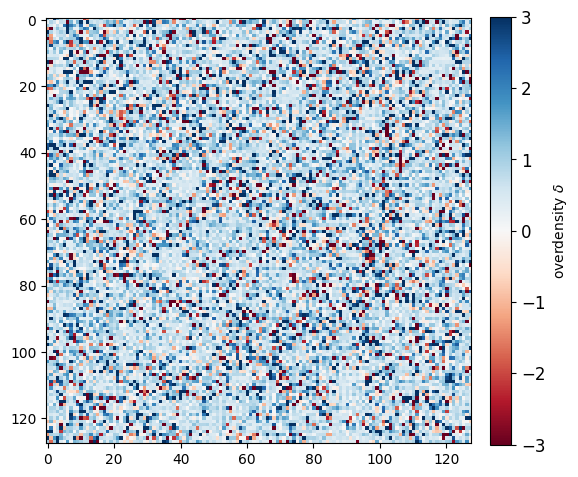

In [156]:
ratio = bias0_normed/pos_ZA_mesh_normed
print("ratio:", np.sum(np.abs(ratio)), np.mean(np.abs(ratio)))
plotter.plot_field(ratio, vmin=-3, vmax=3)

mean std -6.502523e-08 1.0
-8.307907 48.54497
-8.307907 48.54497
(128, 128, 128)
(128, 128)


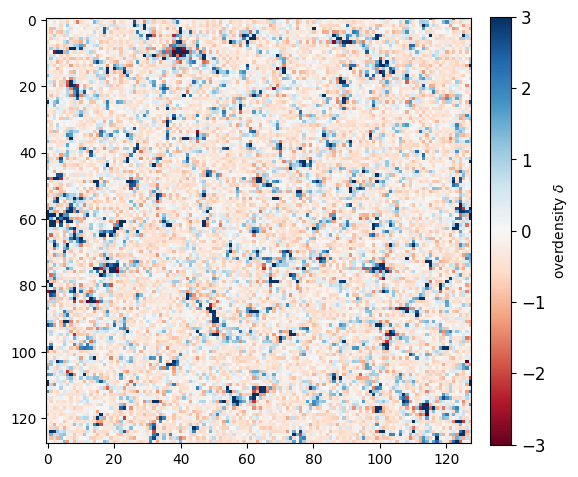

In [157]:
bias0_2 = bias_terms_eul_pred_kcut_deconvolved_2[0]
bias0_normed_2 = (bias0_2 - np.mean(bias0_2))/np.std(bias0_2)
print("mean std", np.mean(bias0_normed_2), np.std(bias0_normed_2))
plotter.plot_field(bias0_normed_2)

ratio: 19419018.0 9.259709
-1792855.6 2436521.8
-1792855.6 2436521.8
(128, 128, 128)
(128, 128)


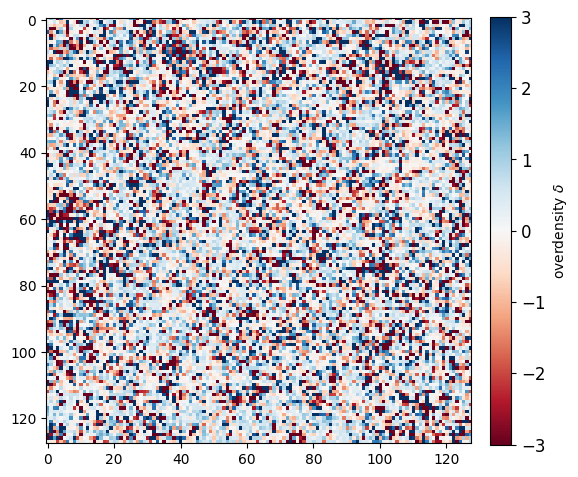

In [158]:
ratio = bias0_normed_2/pos_ZA_mesh_normed
print("ratio:", np.sum(np.abs(ratio)), np.mean(np.abs(ratio)))
plotter.plot_field(ratio, vmin=-3, vmax=3)

dist: 706372.94 0.33682486
1.5010215e-13 1292.958
1.5010215e-13 1292.958
(128, 128, 128)
(128, 128)


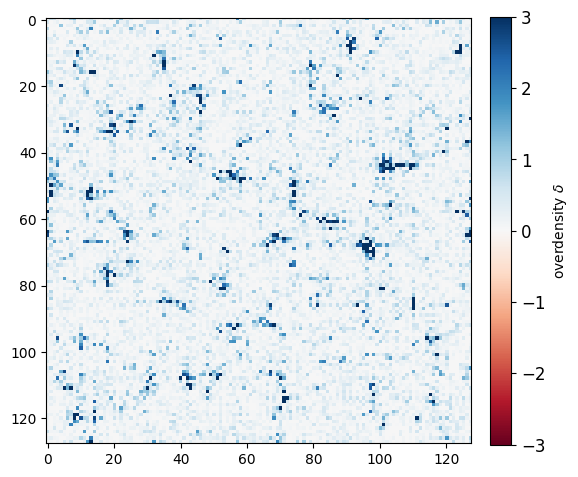

In [159]:
dist = (bias0_normed - pos_ZA_mesh_normed)**2
print("dist:", np.sum(dist), np.mean(dist))
plotter.plot_field(dist, vmin=-3, vmax=3)

dist: 4195065.0 2.0003629
1.0746959e-13 2300.9304
1.0746959e-13 2300.9304
(128, 128, 128)
(128, 128)


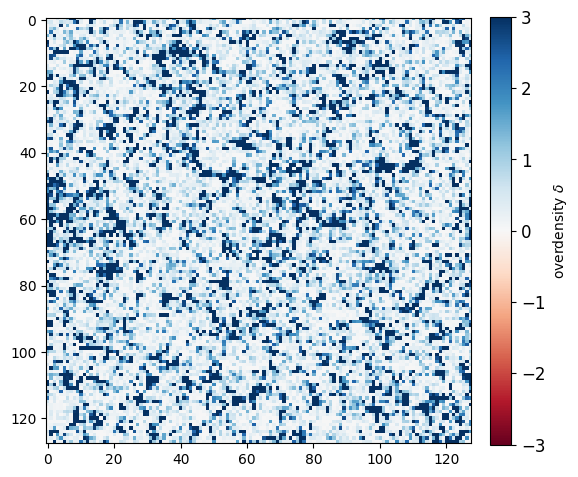

In [160]:
dist = (bias0_normed_2 - pos_ZA_mesh_normed)**2
print("dist:", np.sum(dist), np.mean(dist))
plotter.plot_field(dist, vmin=-3, vmax=3)

### Zspace

In [ ]:
plotter.plot_field(bias)


In [77]:
velocities = sim.sdm['vel']
# vel_field = velocities.reshape((n_grid,n_grid,n_grid,-1))
# vel_field = vel_field.transpose(3,0,1,2)
# velocities = fv2bro(vel_field.copy(order='C'))

In [78]:
grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)
pos_ZA_zspace = bacco.scaler.add_displacement(None,
                                    disp_field,
                                    box=box_size,
                                    #pos=grid.reshape(-1,3),
                                    pos=grid.reshape(-1,3),
                                    vel=velocities,
                                    vel_factor=0,
                                    verbose=True)[0]
#pos_ZA_field_zspace = pos_ZA_zspace.reshape(n_grid, n_grid, n_grid, 3)
pos_ZA_mesh_zspace = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_ZA_zspace, 
                                         deposit_method='cic', interlacing=False)[0]

2024-09-20 01:03:02,990 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 01:03:03,002 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 01:03:03,003 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 01:03:03,012 bacco.statistics :  mesh done in 0.0107 s
INFO:bacco.statistics: mesh done in 0.0107 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000


### Do in loop

In [38]:
i_check = np.arange(100)
idxs_LH_check = idxs_LH[i_check]

In [39]:
idxs_LH_check

array([3857, 3858, 3859, 3861, 3868, 3869, 3870, 3871, 3872, 3873, 3874,
       3875, 3876, 3877, 3882, 3883, 3917, 3918, 3919, 3920, 3921, 3922,
       3923, 3931, 3932, 3938, 3945, 3959, 3960, 3961, 3962, 3963, 3964,
       3965, 3987, 3994, 3995, 3996, 3997, 3998, 3999, 4001, 4002, 4003,
       4004, 4005, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016,
       4017, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4036, 4037, 4038,
       4099, 4100, 4101, 4102, 4106, 4107, 4108, 4109, 4110, 4111, 4112,
       4113, 4114, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128,
       4134, 4135, 4136, 4137, 4138, 4141, 4142, 4143, 4148, 4149, 4150,
       4151])

In [40]:
pos_arr_check = []
bias0_arr_check = []
for idx_LH in idxs_LH_check:
    
    param_dict = params_df.loc[idx_LH].to_dict()
    param_dict.update(param_dict_fixed)
    cosmo = utils.get_cosmo(param_dict, a_scale=expfactor, sim_name='quijote')

    ## Start cosmology class
    expfactor = 1.0
    seed = idx_LH
    sim, disp_field = bacco.utils.create_lpt_simulation(cosmo, box_size, Nmesh=n_grid, Seed=seed,
                                                        FixedInitialAmplitude=False, InitialPhase=0, 
                                                        expfactor=expfactor, LPT_order=1, order_by_order=None,
                                                        phase_type=1, ngenic_phases=True, return_disp=True, 
                                                        sphere_mode=0)

    grid = bacco.visualization.uniform_grid(npix=n_grid, L=box_size, ndim=3, bounds=False)
    pos_ZA = bacco.scaler.add_displacement(None,
                                        disp_field,
                                        box=box_size,
                                        #pos=grid.reshape(-1,3),
                                        pos=grid.reshape(-1,3),
                                        vel=None,
                                        vel_factor=0,
                                        verbose=True)[0]
    pos_ZA_mesh = bacco.statistics.compute_mesh(ngrid=n_grid, box=box_size, pos=pos_ZA, 
                                         deposit_method='cic', interlacing=False)[0]

    # load map2map fields
    dir_LH = f'{dir_mocks}/LH{idx_LH}'
    fn_bfields_kcut_deconvolved = f'{dir_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
    tag_zspace = '_zspace'
    fn_bfields_zspace_kcut_deconvolved = f'{dir_LH}/bias_fields_eul{tag_zspace}_deconvolved_{idx_LH}.npy'
    print(fn_bfields_zspace_kcut_deconvolved)
    bias_terms_eul_pred_kcut_deconvolved = np.load(fn_bfields_zspace_kcut_deconvolved)
    
    # write metric for comparison
    pos_ZA_mesh_normed = (pos_ZA_mesh - np.mean(pos_ZA_mesh))/np.std(pos_ZA_mesh)
    bias0 = bias_terms_eul_pred_kcut_deconvolved[0]
    bias0_normed = (bias0 - np.mean(bias0))/np.std(bias0)
    
    pos_arr_check.append(pos_ZA_mesh_normed)
    bias0_arr_check.append(bias0_normed)

Param tau not in param dict, adding quijote value


2024-09-20 00:40:21,562 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:21,563 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:21,564 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:21,564 bacco.sims : ...done in 0.000823 s
INFO:bacco.sims:...done in 0.000823 s
2024-09-20 00:40:22,547 bacco.scaler : Adding displacement field with a vel-factor=59.725780
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.725780


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3857 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3857 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.725780 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:23,513 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:23,524 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:23,525 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:23,540 bacco.statistics :  mesh done in 0.0158 s
INFO:bacco.statistics: mesh done in 0.0158 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3857/bias_fields_eul_zspace_deconvolved_3857.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:24,218 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:24,219 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:24,219 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:24,220 bacco.sims : ...done in 0.00104 s
INFO:bacco.sims:...done in 0.00104 s
2024-09-20 00:40:25,196 bacco.scaler : Adding displacement field with a vel-factor=49.998772
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.998772


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3858 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3858 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.998772 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:26,150 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:26,161 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:26,161 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:26,171 bacco.statistics :  mesh done in 0.0101 s
INFO:bacco.statistics: mesh done in 0.0101 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3858/bias_fields_eul_zspace_deconvolved_3858.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:26,775 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:26,775 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:26,776 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:26,776 bacco.sims : ...done in 0.000746 s
INFO:bacco.sims:...done in 0.000746 s
2024-09-20 00:40:27,738 bacco.scaler : Adding displacement field with a vel-factor=56.841298
INFO:bacco.scaler:Adding displacement field with a vel-factor=56.841298


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3859 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3859 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=56.841298 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:28,734 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:28,744 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:28,749 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:28,761 bacco.statistics :  mesh done in 0.0173 s
INFO:bacco.statistics: mesh done in 0.0173 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3859/bias_fields_eul_zspace_deconvolved_3859.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:29,340 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:29,341 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:29,342 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:29,342 bacco.sims : ...done in 0.000755 s
INFO:bacco.sims:...done in 0.000755 s
2024-09-20 00:40:30,432 bacco.scaler : Adding displacement field with a vel-factor=57.435165
INFO:bacco.scaler:Adding displacement field with a vel-factor=57.435165


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3861 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3861 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=57.435165 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:31,403 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:31,415 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:31,416 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:31,432 bacco.statistics :  mesh done in 0.0169 s
INFO:bacco.statistics: mesh done in 0.0169 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3861/bias_fields_eul_zspace_deconvolved_3861.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:32,035 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:32,036 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:32,036 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:32,036 bacco.sims : ...done in 0.000778 s
INFO:bacco.sims:...done in 0.000778 s
2024-09-20 00:40:32,959 bacco.scaler : Adding displacement field with a vel-factor=57.542093
INFO:bacco.scaler:Adding displacement field with a vel-factor=57.542093


bacco.lss_scaler : 298 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3868 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3868 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=57.542093 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:33,937 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:33,953 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:33,953 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:33,969 bacco.statistics :  mesh done in 0.0166 s
INFO:bacco.statistics: mesh done in 0.0166 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3868/bias_fields_eul_zspace_deconvolved_3868.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:34,575 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:34,575 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:34,576 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:34,576 bacco.sims : ...done in 0.00076 s
INFO:bacco.sims:...done in 0.00076 s
2024-09-20 00:40:35,545 bacco.scaler : Adding displacement field with a vel-factor=48.834334
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.834334


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3869 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3869 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.834334 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:36,594 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:36,606 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:36,606 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:36,625 bacco.statistics :  mesh done in 0.0198 s
INFO:bacco.statistics: mesh done in 0.0198 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3869/bias_fields_eul_zspace_deconvolved_3869.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:37,283 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:37,284 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:37,284 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:37,285 bacco.sims : ...done in 0.000992 s
INFO:bacco.sims:...done in 0.000992 s
2024-09-20 00:40:38,267 bacco.scaler : Adding displacement field with a vel-factor=44.537053
INFO:bacco.scaler:Adding displacement field with a vel-factor=44.537053


bacco.lss_scaler : 286 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3870 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3870 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=44.537053 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:39,276 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:39,291 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:39,292 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:39,303 bacco.statistics :  mesh done in 0.0118 s
INFO:bacco.statistics: mesh done in 0.0118 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3870/bias_fields_eul_zspace_deconvolved_3870.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:39,846 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:39,847 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:39,847 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:39,847 bacco.sims : ...done in 0.000761 s
INFO:bacco.sims:...done in 0.000761 s
2024-09-20 00:40:40,866 bacco.scaler : Adding displacement field with a vel-factor=52.664428
INFO:bacco.scaler:Adding displacement field with a vel-factor=52.664428


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3871 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3871 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.664428 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:41,872 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:41,883 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:41,884 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:41,896 bacco.statistics :  mesh done in 0.0133 s
INFO:bacco.statistics: mesh done in 0.0133 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3871/bias_fields_eul_zspace_deconvolved_3871.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:42,448 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:42,449 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:42,449 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:42,450 bacco.sims : ...done in 0.000759 s
INFO:bacco.sims:...done in 0.000759 s
2024-09-20 00:40:43,382 bacco.scaler : Adding displacement field with a vel-factor=53.335244
INFO:bacco.scaler:Adding displacement field with a vel-factor=53.335244


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3872 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3872 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.335244 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:44,342 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:44,346 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:44,350 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:44,356 bacco.statistics :  mesh done in 0.0102 s
INFO:bacco.statistics: mesh done in 0.0102 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3872/bias_fields_eul_zspace_deconvolved_3872.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:44,946 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:44,947 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:44,947 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:44,947 bacco.sims : ...done in 0.000745 s
INFO:bacco.sims:...done in 0.000745 s
2024-09-20 00:40:45,920 bacco.scaler : Adding displacement field with a vel-factor=46.899303
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.899303


bacco.lss_scaler : 283 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3873 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3873 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.899303 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:46,937 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:46,950 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:46,952 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:46,965 bacco.statistics :  mesh done in 0.0154 s
INFO:bacco.statistics: mesh done in 0.0154 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3873/bias_fields_eul_zspace_deconvolved_3873.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:47,601 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:47,602 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:47,602 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:47,603 bacco.sims : ...done in 0.000749 s
INFO:bacco.sims:...done in 0.000749 s
2024-09-20 00:40:48,615 bacco.scaler : Adding displacement field with a vel-factor=48.878438
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.878438


bacco.lss_scaler : 288 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3874 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3874 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.878438 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:49,590 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:49,601 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:49,601 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:49,611 bacco.statistics :  mesh done in 0.0104 s
INFO:bacco.statistics: mesh done in 0.0104 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3874/bias_fields_eul_zspace_deconvolved_3874.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:50,193 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:50,194 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:50,195 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:50,195 bacco.sims : ...done in 0.00102 s
INFO:bacco.sims:...done in 0.00102 s
2024-09-20 00:40:51,212 bacco.scaler : Adding displacement field with a vel-factor=53.348527
INFO:bacco.scaler:Adding displacement field with a vel-factor=53.348527


bacco.lss_scaler : 290 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3875 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3875 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.348527 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:52,207 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:52,223 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:52,224 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:52,230 bacco.statistics :  mesh done in 0.00658 s
INFO:bacco.statistics: mesh done in 0.00658 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3875/bias_fields_eul_zspace_deconvolved_3875.npy
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
Param tau not in param dict, adding quijote value


2024-09-20 00:40:52,811 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:52,811 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:52,812 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:52,812 bacco.sims : ...done in 0.000755 s
INFO:bacco.sims:...done in 0.000755 s
2024-09-20 00:40:53,977 bacco.scaler : Adding displacement field with a vel-factor=55.410684
INFO:bacco.scaler:Adding displacement field with a vel-factor=55.410684


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3876 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3876 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=55.410684 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:55,030 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:55,045 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:55,045 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:55,057 bacco.statistics :  mesh done in 0.0124 s
INFO:bacco.statistics: mesh done in 0.0124 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3876/bias_fields_eul_zspace_deconvolved_3876.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:55,650 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:55,651 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:55,651 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:55,652 bacco.sims : ...done in 0.000759 s
INFO:bacco.sims:...done in 0.000759 s
2024-09-20 00:40:56,655 bacco.scaler : Adding displacement field with a vel-factor=45.950344
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.950344


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3877 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3877 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.950344 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:40:57,615 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:40:57,626 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:40:57,630 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:40:57,642 bacco.statistics :  mesh done in 0.0155 s
INFO:bacco.statistics: mesh done in 0.0155 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3877/bias_fields_eul_zspace_deconvolved_3877.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:40:58,203 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:58,204 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:40:58,204 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:40:58,205 bacco.sims : ...done in 0.000758 s
INFO:bacco.sims:...done in 0.000758 s
2024-09-20 00:40:59,385 bacco.scaler : Adding displacement field with a vel-factor=59.167258
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.167258


bacco.lss_scaler : 299 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3882 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3882 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.167258 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:00,429 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:00,444 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:00,445 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:00,456 bacco.statistics :  mesh done in 0.0124 s
INFO:bacco.statistics: mesh done in 0.0124 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3882/bias_fields_eul_zspace_deconvolved_3882.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:01,032 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:01,033 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:01,033 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:01,034 bacco.sims : ...done in 0.000744 s
INFO:bacco.sims:...done in 0.000744 s
2024-09-20 00:41:02,231 bacco.scaler : Adding displacement field with a vel-factor=59.701460
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.701460


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3883 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3883 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.701460 mesh_dtype=4, use_vel=1, use_bias=0


2024-09-20 00:41:03,728 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:03,745 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:03,746 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:03,758 bacco.statistics :  mesh done in 0.0129 s
INFO:bacco.statistics: mesh done in 0.0129 s


bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3883/bias_fields_eul_zspace_deconvolved_3883.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:04,374 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:04,375 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:04,375 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:04,376 bacco.sims : ...done in 0.000917 s
INFO:bacco.sims:...done in 0.000917 s
2024-09-20 00:41:05,370 bacco.scaler : Adding displacement field with a vel-factor=56.027050
INFO:bacco.scaler:Adding displacement field with a vel-factor=56.027050


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3917 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3917 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=56.027050 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:06,390 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:06,402 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:06,402 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:06,412 bacco.statistics :  mesh done in 0.0107 s
INFO:bacco.statistics: mesh done in 0.0107 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3917/bias_fields_eul_zspace_deconvolved_3917.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:06,967 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:06,968 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:06,969 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:06,969 bacco.sims : ...done in 0.000758 s
INFO:bacco.sims:...done in 0.000758 s
2024-09-20 00:41:07,950 bacco.scaler : Adding displacement field with a vel-factor=48.294520
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.294520


bacco.lss_scaler : 287 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3918 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3918 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.294520 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:08,951 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:08,963 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:08,963 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:08,979 bacco.statistics :  mesh done in 0.0158 s
INFO:bacco.statistics: mesh done in 0.0158 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3918/bias_fields_eul_zspace_deconvolved_3918.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:09,575 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:09,576 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:09,576 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:09,576 bacco.sims : ...done in 0.000743 s
INFO:bacco.sims:...done in 0.000743 s
2024-09-20 00:41:10,562 bacco.scaler : Adding displacement field with a vel-factor=46.206561
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.206561


bacco.lss_scaler : 283 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3919 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3919 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.206561 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:11,578 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:11,589 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:11,589 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:11,606 bacco.statistics :  mesh done in 0.0173 s
INFO:bacco.statistics: mesh done in 0.0173 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3919/bias_fields_eul_zspace_deconvolved_3919.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:12,176 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:12,176 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:12,177 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:12,177 bacco.sims : ...done in 0.000736 s
INFO:bacco.sims:...done in 0.000736 s
2024-09-20 00:41:13,174 bacco.scaler : Adding displacement field with a vel-factor=54.024700
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.024700


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3920 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3920 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.024700 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:14,182 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:14,196 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:14,197 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:14,208 bacco.statistics :  mesh done in 0.0121 s
INFO:bacco.statistics: mesh done in 0.0121 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3920/bias_fields_eul_zspace_deconvolved_3920.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:14,809 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:14,810 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:14,811 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:14,811 bacco.sims : ...done in 0.000757 s
INFO:bacco.sims:...done in 0.000757 s
2024-09-20 00:41:15,747 bacco.scaler : Adding displacement field with a vel-factor=54.861375
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.861375


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3921 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3921 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.861375 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:16,752 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:16,771 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:16,772 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:16,789 bacco.statistics :  mesh done in 0.0182 s
INFO:bacco.statistics: mesh done in 0.0182 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3921/bias_fields_eul_zspace_deconvolved_3921.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:17,366 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:17,366 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:17,366 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:17,367 bacco.sims : ...done in 0.000737 s
INFO:bacco.sims:...done in 0.000737 s
2024-09-20 00:41:18,456 bacco.scaler : Adding displacement field with a vel-factor=46.048536
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.048536


bacco.lss_scaler : 286 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3922 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3922 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.048536 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:19,462 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:19,474 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:19,475 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:19,484 bacco.statistics :  mesh done in 0.0101 s
INFO:bacco.statistics: mesh done in 0.0101 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3922/bias_fields_eul_zspace_deconvolved_3922.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:20,111 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:20,112 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:20,113 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:20,113 bacco.sims : ...done in 0.00077 s
INFO:bacco.sims:...done in 0.00077 s
2024-09-20 00:41:21,067 bacco.scaler : Adding displacement field with a vel-factor=48.576127
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.576127


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3923 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3923 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table


2024-09-20 00:41:22,064 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:22,074 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:22,075 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:22,084 bacco.statistics :  mesh done in 0.00953 s
INFO:bacco.statistics: mesh done in 0.00953 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.576127 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3923/bias_fields_eul_zspace_deconvolved_3923.npy
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
Param tau not in param dict, adding quijote value


2024-09-20 00:41:22,669 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:22,669 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:22,670 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:22,670 bacco.sims : ...done in 0.000738 s
INFO:bacco.sims:...done in 0.000738 s
2024-09-20 00:41:23,634 bacco.scaler : Adding displacement field with a vel-factor=57.786147
INFO:bacco.scaler:Adding displacement field with a vel-factor=57.786147


bacco.lss_scaler : 300 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3931 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3931 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=57.786147 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:24,621 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:24,633 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:24,634 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:24,648 bacco.statistics :  mesh done in 0.0151 s
INFO:bacco.statistics: mesh done in 0.0151 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3931/bias_fields_eul_zspace_deconvolved_3931.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:25,210 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:25,211 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:25,211 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:25,212 bacco.sims : ...done in 0.000731 s
INFO:bacco.sims:...done in 0.000731 s
2024-09-20 00:41:26,172 bacco.scaler : Adding displacement field with a vel-factor=59.223117
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.223117


bacco.lss_scaler : 299 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3932 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3932 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.223117 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:27,192 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:27,203 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:27,203 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:27,211 bacco.statistics :  mesh done in 0.00866 s
INFO:bacco.statistics: mesh done in 0.00866 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3932/bias_fields_eul_zspace_deconvolved_3932.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:27,775 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:27,775 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:27,776 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:27,776 bacco.sims : ...done in 0.00101 s
INFO:bacco.sims:...done in 0.00101 s
2024-09-20 00:41:28,813 bacco.scaler : Adding displacement field with a vel-factor=46.600541
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.600541


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3938 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3938 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.600541 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:29,842 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:29,855 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:29,856 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:29,871 bacco.statistics :  mesh done in 0.016 s
INFO:bacco.statistics: mesh done in 0.016 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3938/bias_fields_eul_zspace_deconvolved_3938.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:30,445 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:30,446 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:30,446 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:30,447 bacco.sims : ...done in 0.000771 s
INFO:bacco.sims:...done in 0.000771 s
2024-09-20 00:41:31,471 bacco.scaler : Adding displacement field with a vel-factor=58.556074
INFO:bacco.scaler:Adding displacement field with a vel-factor=58.556074


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3945 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3945 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=58.556074 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:32,461 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:32,471 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:32,476 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:32,488 bacco.statistics :  mesh done in 0.0166 s
INFO:bacco.statistics: mesh done in 0.0166 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3945/bias_fields_eul_zspace_deconvolved_3945.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:33,058 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:33,059 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:33,059 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:33,060 bacco.sims : ...done in 0.000768 s
INFO:bacco.sims:...done in 0.000768 s
2024-09-20 00:41:34,266 bacco.scaler : Adding displacement field with a vel-factor=48.552269
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.552269


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3959 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3959 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.552269 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:35,283 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:35,298 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:35,298 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:35,305 bacco.statistics :  mesh done in 0.00692 s
INFO:bacco.statistics: mesh done in 0.00692 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3959/bias_fields_eul_zspace_deconvolved_3959.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:35,844 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:35,844 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:35,845 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:35,845 bacco.sims : ...done in 0.000719 s
INFO:bacco.sims:...done in 0.000719 s
2024-09-20 00:41:36,886 bacco.scaler : Adding displacement field with a vel-factor=46.053214
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.053214


bacco.lss_scaler : 286 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3960 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3960 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.053214 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:37,891 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:37,905 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:37,906 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:37,918 bacco.statistics :  mesh done in 0.0122 s
INFO:bacco.statistics: mesh done in 0.0122 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3960/bias_fields_eul_zspace_deconvolved_3960.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:38,531 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:38,531 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:38,532 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:38,532 bacco.sims : ...done in 0.000733 s
INFO:bacco.sims:...done in 0.000733 s
2024-09-20 00:41:39,456 bacco.scaler : Adding displacement field with a vel-factor=54.895287
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.895287


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3961 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3961 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.895287 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:40,472 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:40,483 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:40,484 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:40,496 bacco.statistics :  mesh done in 0.0134 s
INFO:bacco.statistics: mesh done in 0.0134 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3961/bias_fields_eul_zspace_deconvolved_3961.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:41,060 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:41,061 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:41,061 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:41,062 bacco.sims : ...done in 0.000988 s
INFO:bacco.sims:...done in 0.000988 s
2024-09-20 00:41:42,029 bacco.scaler : Adding displacement field with a vel-factor=58.613629
INFO:bacco.scaler:Adding displacement field with a vel-factor=58.613629


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3962 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3962 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=58.613629 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:43,044 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:43,055 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:43,055 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:43,067 bacco.statistics :  mesh done in 0.0126 s
INFO:bacco.statistics: mesh done in 0.0126 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3962/bias_fields_eul_zspace_deconvolved_3962.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:43,628 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:43,629 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:43,629 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:43,630 bacco.sims : ...done in 0.000996 s
INFO:bacco.sims:...done in 0.000996 s
2024-09-20 00:41:44,596 bacco.scaler : Adding displacement field with a vel-factor=56.652875
INFO:bacco.scaler:Adding displacement field with a vel-factor=56.652875


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3963 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3963 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=56.652875 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:45,585 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:45,598 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:45,601 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:45,612 bacco.statistics :  mesh done in 0.0131 s
INFO:bacco.statistics: mesh done in 0.0131 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3963/bias_fields_eul_zspace_deconvolved_3963.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:46,595 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:46,596 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:46,596 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:46,597 bacco.sims : ...done in 0.000928 s
INFO:bacco.sims:...done in 0.000928 s
2024-09-20 00:41:47,563 bacco.scaler : Adding displacement field with a vel-factor=58.094121
INFO:bacco.scaler:Adding displacement field with a vel-factor=58.094121


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3964 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3964 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=58.094121 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:48,563 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:48,574 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:48,574 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:48,588 bacco.statistics :  mesh done in 0.0138 s
INFO:bacco.statistics: mesh done in 0.0138 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3964/bias_fields_eul_zspace_deconvolved_3964.npy
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
Param tau not in param dict, adding quijote value


2024-09-20 00:41:49,204 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:49,205 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:49,205 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:49,206 bacco.sims : ...done in 0.000752 s
INFO:bacco.sims:...done in 0.000752 s
2024-09-20 00:41:50,133 bacco.scaler : Adding displacement field with a vel-factor=55.883614
INFO:bacco.scaler:Adding displacement field with a vel-factor=55.883614


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3965 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3965 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=55.883614 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:51,137 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:51,148 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:51,149 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:51,159 bacco.statistics :  mesh done in 0.0115 s
INFO:bacco.statistics: mesh done in 0.0115 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3965/bias_fields_eul_zspace_deconvolved_3965.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:51,754 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:51,754 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:51,755 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:51,755 bacco.sims : ...done in 0.000737 s
INFO:bacco.sims:...done in 0.000737 s
2024-09-20 00:41:52,709 bacco.scaler : Adding displacement field with a vel-factor=45.519460
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.519460


bacco.lss_scaler : 285 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3987 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3987 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.519460 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:53,705 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:53,715 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:53,716 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:53,728 bacco.statistics :  mesh done in 0.0127 s
INFO:bacco.statistics: mesh done in 0.0127 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3987/bias_fields_eul_zspace_deconvolved_3987.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:54,361 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:54,362 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:54,362 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:54,363 bacco.sims : ...done in 0.00098 s
INFO:bacco.sims:...done in 0.00098 s
2024-09-20 00:41:55,398 bacco.scaler : Adding displacement field with a vel-factor=50.673746
INFO:bacco.scaler:Adding displacement field with a vel-factor=50.673746


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3994 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3994 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=50.673746 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:56,428 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:56,443 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:56,444 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:56,457 bacco.statistics :  mesh done in 0.0145 s
INFO:bacco.statistics: mesh done in 0.0145 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3994/bias_fields_eul_zspace_deconvolved_3994.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:57,000 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:57,000 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:57,001 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:57,001 bacco.sims : ...done in 0.000745 s
INFO:bacco.sims:...done in 0.000745 s
2024-09-20 00:41:58,044 bacco.scaler : Adding displacement field with a vel-factor=58.843789
INFO:bacco.scaler:Adding displacement field with a vel-factor=58.843789


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3995 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3995 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=58.843789 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:41:59,051 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:41:59,062 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:41:59,063 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:41:59,074 bacco.statistics :  mesh done in 0.0112 s
INFO:bacco.statistics: mesh done in 0.0112 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3995/bias_fields_eul_zspace_deconvolved_3995.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:41:59,637 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:59,637 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:41:59,638 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:41:59,638 bacco.sims : ...done in 0.000744 s
INFO:bacco.sims:...done in 0.000744 s
2024-09-20 00:42:00,622 bacco.scaler : Adding displacement field with a vel-factor=51.402968
INFO:bacco.scaler:Adding displacement field with a vel-factor=51.402968


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3996 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3996 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=51.402968 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:01,652 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:01,662 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:01,663 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:01,677 bacco.statistics :  mesh done in 0.0145 s
INFO:bacco.statistics: mesh done in 0.0145 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3996/bias_fields_eul_zspace_deconvolved_3996.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:02,227 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:02,227 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:02,228 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:02,228 bacco.sims : ...done in 0.000738 s
INFO:bacco.sims:...done in 0.000738 s
2024-09-20 00:42:03,193 bacco.scaler : Adding displacement field with a vel-factor=53.986952
INFO:bacco.scaler:Adding displacement field with a vel-factor=53.986952


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3997 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3997 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.986952 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:04,179 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:04,183 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:04,188 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:04,202 bacco.statistics :  mesh done in 0.0185 s
INFO:bacco.statistics: mesh done in 0.0185 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3997/bias_fields_eul_zspace_deconvolved_3997.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:04,842 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:04,843 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:04,843 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:04,843 bacco.sims : ...done in 0.000742 s
INFO:bacco.sims:...done in 0.000742 s
2024-09-20 00:42:05,787 bacco.scaler : Adding displacement field with a vel-factor=60.238885
INFO:bacco.scaler:Adding displacement field with a vel-factor=60.238885


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3998 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3998 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=60.238885 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:06,754 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:06,765 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:06,766 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:06,779 bacco.statistics :  mesh done in 0.0138 s
INFO:bacco.statistics: mesh done in 0.0138 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3998/bias_fields_eul_zspace_deconvolved_3998.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:07,350 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:07,351 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:07,352 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:07,352 bacco.sims : ...done in 0.00087 s
INFO:bacco.sims:...done in 0.00087 s
2024-09-20 00:42:08,300 bacco.scaler : Adding displacement field with a vel-factor=46.027635
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.027635


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =3999 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =3999 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.027635 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:09,359 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:09,370 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:09,370 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:09,388 bacco.statistics :  mesh done in 0.0182 s
INFO:bacco.statistics: mesh done in 0.0182 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH3999/bias_fields_eul_zspace_deconvolved_3999.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:09,994 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:09,994 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:09,995 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:09,995 bacco.sims : ...done in 0.000748 s
INFO:bacco.sims:...done in 0.000748 s
2024-09-20 00:42:11,030 bacco.scaler : Adding displacement field with a vel-factor=51.877279
INFO:bacco.scaler:Adding displacement field with a vel-factor=51.877279


bacco.lss_scaler : 288 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4001 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4001 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=51.877279 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:12,019 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:12,029 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:12,030 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:12,043 bacco.statistics :  mesh done in 0.0138 s
INFO:bacco.statistics: mesh done in 0.0138 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4001/bias_fields_eul_zspace_deconvolved_4001.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:12,621 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:12,622 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:12,622 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:12,623 bacco.sims : ...done in 0.000767 s
INFO:bacco.sims:...done in 0.000767 s
2024-09-20 00:42:13,567 bacco.scaler : Adding displacement field with a vel-factor=59.756721
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.756721


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4002 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4002 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.756721 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:14,568 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:14,583 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:14,584 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:14,601 bacco.statistics :  mesh done in 0.0182 s
INFO:bacco.statistics: mesh done in 0.0182 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4002/bias_fields_eul_zspace_deconvolved_4002.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:15,235 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:15,235 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:15,236 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:15,236 bacco.sims : ...done in 0.000739 s
INFO:bacco.sims:...done in 0.000739 s
2024-09-20 00:42:16,220 bacco.scaler : Adding displacement field with a vel-factor=52.308386
INFO:bacco.scaler:Adding displacement field with a vel-factor=52.308386


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4003 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4003 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.308386 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:17,709 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:17,720 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:17,721 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:17,739 bacco.statistics :  mesh done in 0.019 s
INFO:bacco.statistics: mesh done in 0.019 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4003/bias_fields_eul_zspace_deconvolved_4003.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:18,554 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:18,555 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:18,555 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:18,556 bacco.sims : ...done in 0.000758 s
INFO:bacco.sims:...done in 0.000758 s
2024-09-20 00:42:19,969 bacco.scaler : Adding displacement field with a vel-factor=49.560199
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.560199


bacco.lss_scaler : 285 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4004 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4004 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.560199 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:21,022 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:21,036 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:21,037 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:21,048 bacco.statistics :  mesh done in 0.0119 s
INFO:bacco.statistics: mesh done in 0.0119 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4004/bias_fields_eul_zspace_deconvolved_4004.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:21,697 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:21,698 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:21,698 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:21,699 bacco.sims : ...done in 0.000725 s
INFO:bacco.sims:...done in 0.000725 s
2024-09-20 00:42:22,710 bacco.scaler : Adding displacement field with a vel-factor=57.964717
INFO:bacco.scaler:Adding displacement field with a vel-factor=57.964717


bacco.lss_scaler : 301 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4005 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4005 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=57.964717 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:23,709 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:23,721 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:23,722 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:23,731 bacco.statistics :  mesh done in 0.00969 s
INFO:bacco.statistics: mesh done in 0.00969 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4005/bias_fields_eul_zspace_deconvolved_4005.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:24,293 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:24,294 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:24,294 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:24,294 bacco.sims : ...done in 0.000771 s
INFO:bacco.sims:...done in 0.000771 s
2024-09-20 00:42:25,272 bacco.scaler : Adding displacement field with a vel-factor=45.474399
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.474399


bacco.lss_scaler : 290 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4008 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4008 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.474399 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:26,296 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:26,308 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:26,309 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:26,324 bacco.statistics :  mesh done in 0.0164 s
INFO:bacco.statistics: mesh done in 0.0164 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4008/bias_fields_eul_zspace_deconvolved_4008.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:26,864 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:26,865 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:26,865 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:26,865 bacco.sims : ...done in 0.000764 s
INFO:bacco.sims:...done in 0.000764 s
2024-09-20 00:42:27,899 bacco.scaler : Adding displacement field with a vel-factor=45.429610
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.429610


bacco.lss_scaler : 285 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4009 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4009 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.429610 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:28,933 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:28,943 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:28,948 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:28,959 bacco.statistics :  mesh done in 0.0163 s
INFO:bacco.statistics: mesh done in 0.0163 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4009/bias_fields_eul_zspace_deconvolved_4009.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:29,527 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:29,528 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:29,528 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:29,529 bacco.sims : ...done in 0.000749 s
INFO:bacco.sims:...done in 0.000749 s
2024-09-20 00:42:30,627 bacco.scaler : Adding displacement field with a vel-factor=59.882501
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.882501


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4010 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4010 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.882501 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:31,622 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:31,634 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:31,635 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:31,648 bacco.statistics :  mesh done in 0.0135 s
INFO:bacco.statistics: mesh done in 0.0135 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4010/bias_fields_eul_zspace_deconvolved_4010.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:32,202 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:32,203 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:32,203 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:32,204 bacco.sims : ...done in 0.0012 s
INFO:bacco.sims:...done in 0.0012 s
2024-09-20 00:42:33,164 bacco.scaler : Adding displacement field with a vel-factor=47.829000
INFO:bacco.scaler:Adding displacement field with a vel-factor=47.829000


bacco.lss_scaler : 287 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4011 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4011 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=47.829000 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:34,140 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:34,152 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:34,152 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:34,167 bacco.statistics :  mesh done in 0.0157 s
INFO:bacco.statistics: mesh done in 0.0157 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4011/bias_fields_eul_zspace_deconvolved_4011.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:34,730 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:34,731 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:34,731 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:34,732 bacco.sims : ...done in 0.000766 s
INFO:bacco.sims:...done in 0.000766 s
2024-09-20 00:42:35,682 bacco.scaler : Adding displacement field with a vel-factor=58.336428
INFO:bacco.scaler:Adding displacement field with a vel-factor=58.336428


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4012 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4012 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=58.336428 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:37,182 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:37,193 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:37,194 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:37,207 bacco.statistics :  mesh done in 0.0144 s
INFO:bacco.statistics: mesh done in 0.0144 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4012/bias_fields_eul_zspace_deconvolved_4012.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:37,998 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:37,999 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:37,999 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:38,000 bacco.sims : ...done in 0.00121 s
INFO:bacco.sims:...done in 0.00121 s
2024-09-20 00:42:39,250 bacco.scaler : Adding displacement field with a vel-factor=59.192279
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.192279


bacco.lss_scaler : 299 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4013 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4013 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.192279 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:40,286 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:40,300 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:40,301 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:40,320 bacco.statistics :  mesh done in 0.0198 s
INFO:bacco.statistics: mesh done in 0.0198 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4013/bias_fields_eul_zspace_deconvolved_4013.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:40,905 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:40,906 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:40,906 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:40,907 bacco.sims : ...done in 0.000733 s
INFO:bacco.sims:...done in 0.000733 s
2024-09-20 00:42:41,913 bacco.scaler : Adding displacement field with a vel-factor=44.991875
INFO:bacco.scaler:Adding displacement field with a vel-factor=44.991875


bacco.lss_scaler : 287 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4014 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4014 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=44.991875 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:42,907 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:42,920 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:42,921 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:42,931 bacco.statistics :  mesh done in 0.0105 s
INFO:bacco.statistics: mesh done in 0.0105 s


/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4014/bias_fields_eul_zspace_deconvolved_4014.npy
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
Param tau not in param dict, adding quijote value


2024-09-20 00:42:43,754 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:43,754 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:43,755 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:43,755 bacco.sims : ...done in 0.000922 s
INFO:bacco.sims:...done in 0.000922 s
2024-09-20 00:42:44,716 bacco.scaler : Adding displacement field with a vel-factor=50.119358
INFO:bacco.scaler:Adding displacement field with a vel-factor=50.119358


bacco.lss_scaler : 290 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4015 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4015 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=50.119358 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:45,701 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:45,714 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:45,716 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:45,729 bacco.statistics :  mesh done in 0.0156 s
INFO:bacco.statistics: mesh done in 0.0156 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4015/bias_fields_eul_zspace_deconvolved_4015.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:46,293 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:46,293 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:46,293 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:46,294 bacco.sims : ...done in 0.000743 s
INFO:bacco.sims:...done in 0.000743 s
2024-09-20 00:42:47,234 bacco.scaler : Adding displacement field with a vel-factor=51.390622
INFO:bacco.scaler:Adding displacement field with a vel-factor=51.390622


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4016 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4016 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=51.390622 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:48,216 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:48,221 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:48,225 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:48,232 bacco.statistics :  mesh done in 0.0118 s
INFO:bacco.statistics: mesh done in 0.0118 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4016/bias_fields_eul_zspace_deconvolved_4016.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:49,051 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:49,052 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:49,053 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:49,053 bacco.sims : ...done in 0.00119 s
INFO:bacco.sims:...done in 0.00119 s
2024-09-20 00:42:50,439 bacco.scaler : Adding displacement field with a vel-factor=54.046484
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.046484


bacco.lss_scaler : 288 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4017 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4017 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.046484 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:51,903 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:51,918 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:51,919 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:51,934 bacco.statistics :  mesh done in 0.0162 s
INFO:bacco.statistics: mesh done in 0.0162 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4017/bias_fields_eul_zspace_deconvolved_4017.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:52,597 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:52,598 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:52,599 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:52,599 bacco.sims : ...done in 0.00101 s
INFO:bacco.sims:...done in 0.00101 s
2024-09-20 00:42:53,636 bacco.scaler : Adding displacement field with a vel-factor=54.655730
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.655730


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4022 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4022 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.655730 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:54,652 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:54,663 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:54,664 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:54,677 bacco.statistics :  mesh done in 0.0133 s
INFO:bacco.statistics: mesh done in 0.0133 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4022/bias_fields_eul_zspace_deconvolved_4022.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:55,262 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:55,263 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:55,263 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:55,264 bacco.sims : ...done in 0.00103 s
INFO:bacco.sims:...done in 0.00103 s
2024-09-20 00:42:56,222 bacco.scaler : Adding displacement field with a vel-factor=52.411354
INFO:bacco.scaler:Adding displacement field with a vel-factor=52.411354


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4023 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4023 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.411354 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:57,224 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:57,235 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:57,235 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:57,254 bacco.statistics :  mesh done in 0.0199 s
INFO:bacco.statistics: mesh done in 0.0199 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4023/bias_fields_eul_zspace_deconvolved_4023.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:42:57,816 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:57,817 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:42:57,817 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:42:57,818 bacco.sims : ...done in 0.000956 s
INFO:bacco.sims:...done in 0.000956 s
2024-09-20 00:42:58,817 bacco.scaler : Adding displacement field with a vel-factor=51.826164
INFO:bacco.scaler:Adding displacement field with a vel-factor=51.826164


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4024 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4024 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=51.826164 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:42:59,812 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:42:59,822 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:42:59,826 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:42:59,843 bacco.statistics :  mesh done in 0.0206 s
INFO:bacco.statistics: mesh done in 0.0206 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4024/bias_fields_eul_zspace_deconvolved_4024.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:00,424 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:00,425 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:00,425 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:00,425 bacco.sims : ...done in 0.00078 s
INFO:bacco.sims:...done in 0.00078 s
2024-09-20 00:43:01,489 bacco.scaler : Adding displacement field with a vel-factor=49.438463
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.438463


bacco.lss_scaler : 290 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4025 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4025 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.438463 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:02,491 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:02,502 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:02,506 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:02,512 bacco.statistics :  mesh done in 0.00949 s
INFO:bacco.statistics: mesh done in 0.00949 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4025/bias_fields_eul_zspace_deconvolved_4025.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:03,134 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:03,134 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:03,135 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:03,135 bacco.sims : ...done in 0.000755 s
INFO:bacco.sims:...done in 0.000755 s
2024-09-20 00:43:04,459 bacco.scaler : Adding displacement field with a vel-factor=48.512463
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.512463


bacco.lss_scaler : 286 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4026 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4026 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.512463 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:05,497 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:05,507 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:05,508 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:05,521 bacco.statistics :  mesh done in 0.014 s
INFO:bacco.statistics: mesh done in 0.014 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4026/bias_fields_eul_zspace_deconvolved_4026.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:06,118 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:06,119 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:06,119 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:06,120 bacco.sims : ...done in 0.000766 s
INFO:bacco.sims:...done in 0.000766 s
2024-09-20 00:43:07,098 bacco.scaler : Adding displacement field with a vel-factor=52.141922
INFO:bacco.scaler:Adding displacement field with a vel-factor=52.141922


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4027 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4027 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=52.141922 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:08,129 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:08,139 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:08,140 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:08,159 bacco.statistics :  mesh done in 0.02 s
INFO:bacco.statistics: mesh done in 0.02 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4027/bias_fields_eul_zspace_deconvolved_4027.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:08,722 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:08,723 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:08,723 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:08,723 bacco.sims : ...done in 0.000755 s
INFO:bacco.sims:...done in 0.000755 s
2024-09-20 00:43:09,789 bacco.scaler : Adding displacement field with a vel-factor=47.315525
INFO:bacco.scaler:Adding displacement field with a vel-factor=47.315525


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4028 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4028 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=47.315525 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:10,803 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:10,818 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:10,819 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:10,830 bacco.statistics :  mesh done in 0.0126 s
INFO:bacco.statistics: mesh done in 0.0126 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4028/bias_fields_eul_zspace_deconvolved_4028.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:11,392 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:11,393 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:11,393 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:11,393 bacco.sims : ...done in 0.000756 s
INFO:bacco.sims:...done in 0.000756 s
2024-09-20 00:43:12,419 bacco.scaler : Adding displacement field with a vel-factor=49.044560
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.044560


bacco.lss_scaler : 285 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4036 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4036 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.044560 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:13,429 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:13,444 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:13,445 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:13,456 bacco.statistics :  mesh done in 0.0122 s
INFO:bacco.statistics: mesh done in 0.0122 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4036/bias_fields_eul_zspace_deconvolved_4036.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:14,035 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:14,036 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:14,036 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:14,037 bacco.sims : ...done in 0.000738 s
INFO:bacco.sims:...done in 0.000738 s
2024-09-20 00:43:14,974 bacco.scaler : Adding displacement field with a vel-factor=59.218184
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.218184


bacco.lss_scaler : 300 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4037 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4037 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.218184 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:15,988 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:16,003 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:16,004 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:16,015 bacco.statistics :  mesh done in 0.0117 s
INFO:bacco.statistics: mesh done in 0.0117 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4037/bias_fields_eul_zspace_deconvolved_4037.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:16,584 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:16,584 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:16,585 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:16,585 bacco.sims : ...done in 0.00072 s
INFO:bacco.sims:...done in 0.00072 s
2024-09-20 00:43:17,724 bacco.scaler : Adding displacement field with a vel-factor=56.060978
INFO:bacco.scaler:Adding displacement field with a vel-factor=56.060978


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4038 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4038 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=56.060978 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:18,744 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:18,756 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:18,756 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:18,773 bacco.statistics :  mesh done in 0.0173 s
INFO:bacco.statistics: mesh done in 0.0173 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4038/bias_fields_eul_zspace_deconvolved_4038.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:19,344 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:19,344 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:19,345 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:19,345 bacco.sims : ...done in 0.000727 s
INFO:bacco.sims:...done in 0.000727 s
2024-09-20 00:43:20,433 bacco.scaler : Adding displacement field with a vel-factor=55.267746
INFO:bacco.scaler:Adding displacement field with a vel-factor=55.267746


bacco.lss_scaler : 299 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4099 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4099 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=55.267746 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:21,436 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:21,446 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:21,447 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:21,460 bacco.statistics :  mesh done in 0.0139 s
INFO:bacco.statistics: mesh done in 0.0139 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4099/bias_fields_eul_zspace_deconvolved_4099.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:22,062 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:22,062 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:22,063 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:22,063 bacco.sims : ...done in 0.00104 s
INFO:bacco.sims:...done in 0.00104 s
2024-09-20 00:43:23,072 bacco.scaler : Adding displacement field with a vel-factor=48.446127
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.446127


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4100 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4100 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.446127 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:24,087 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:24,099 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:24,100 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:24,113 bacco.statistics :  mesh done in 0.0139 s
INFO:bacco.statistics: mesh done in 0.0139 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4100/bias_fields_eul_zspace_deconvolved_4100.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:24,691 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:24,692 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:24,692 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:24,693 bacco.sims : ...done in 0.000746 s
INFO:bacco.sims:...done in 0.000746 s
2024-09-20 00:43:25,763 bacco.scaler : Adding displacement field with a vel-factor=54.163899
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.163899


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4101 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4101 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.163899 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:26,829 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:26,833 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:26,838 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:26,849 bacco.statistics :  mesh done in 0.0159 s
INFO:bacco.statistics: mesh done in 0.0159 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4101/bias_fields_eul_zspace_deconvolved_4101.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:27,440 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:27,441 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:27,441 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:27,442 bacco.sims : ...done in 0.000908 s
INFO:bacco.sims:...done in 0.000908 s
2024-09-20 00:43:28,371 bacco.scaler : Adding displacement field with a vel-factor=59.236576
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.236576


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4102 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4102 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.236576 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:29,364 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:29,379 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:29,380 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:29,391 bacco.statistics :  mesh done in 0.0124 s
INFO:bacco.statistics: mesh done in 0.0124 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4102/bias_fields_eul_zspace_deconvolved_4102.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:29,971 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:29,972 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:29,973 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:29,973 bacco.sims : ...done in 0.000919 s
INFO:bacco.sims:...done in 0.000919 s
2024-09-20 00:43:30,960 bacco.scaler : Adding displacement field with a vel-factor=54.755755
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.755755


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4106 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4106 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.755755 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:31,968 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:31,979 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:31,983 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:31,989 bacco.statistics :  mesh done in 0.0105 s
INFO:bacco.statistics: mesh done in 0.0105 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4106/bias_fields_eul_zspace_deconvolved_4106.npy
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
Param tau not in param dict, adding quijote value


2024-09-20 00:43:32,547 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:32,548 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:32,548 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:32,549 bacco.sims : ...done in 0.00077 s
INFO:bacco.sims:...done in 0.00077 s
2024-09-20 00:43:33,544 bacco.scaler : Adding displacement field with a vel-factor=47.849139
INFO:bacco.scaler:Adding displacement field with a vel-factor=47.849139


bacco.lss_scaler : 285 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4107 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4107 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=47.849139 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:34,540 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:34,551 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:34,552 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:34,565 bacco.statistics :  mesh done in 0.0133 s
INFO:bacco.statistics: mesh done in 0.0133 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4107/bias_fields_eul_zspace_deconvolved_4107.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:35,176 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:35,177 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:35,177 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:35,178 bacco.sims : ...done in 0.000721 s
INFO:bacco.sims:...done in 0.000721 s
2024-09-20 00:43:36,386 bacco.scaler : Adding displacement field with a vel-factor=57.314486
INFO:bacco.scaler:Adding displacement field with a vel-factor=57.314486


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4108 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4108 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=57.314486 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:37,502 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:37,513 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:37,514 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:37,526 bacco.statistics :  mesh done in 0.0131 s
INFO:bacco.statistics: mesh done in 0.0131 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4108/bias_fields_eul_zspace_deconvolved_4108.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:38,145 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:38,146 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:38,146 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:38,147 bacco.sims : ...done in 0.000767 s
INFO:bacco.sims:...done in 0.000767 s
2024-09-20 00:43:39,298 bacco.scaler : Adding displacement field with a vel-factor=49.481486
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.481486


bacco.lss_scaler : 290 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4109 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4109 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.481486 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:40,387 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:40,398 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:40,402 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:40,421 bacco.statistics :  mesh done in 0.0225 s
INFO:bacco.statistics: mesh done in 0.0225 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4109/bias_fields_eul_zspace_deconvolved_4109.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:41,036 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:41,036 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:41,037 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:41,037 bacco.sims : ...done in 0.000764 s
INFO:bacco.sims:...done in 0.000764 s
2024-09-20 00:43:42,095 bacco.scaler : Adding displacement field with a vel-factor=45.551808
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.551808


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4110 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4110 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.551808 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:43,145 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:43,156 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:43,157 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:43,168 bacco.statistics :  mesh done in 0.0123 s
INFO:bacco.statistics: mesh done in 0.0123 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4110/bias_fields_eul_zspace_deconvolved_4110.npy
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
Param tau not in param dict, adding quijote value


2024-09-20 00:43:43,779 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:43,779 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:43,780 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:43,780 bacco.sims : ...done in 0.000726 s
INFO:bacco.sims:...done in 0.000726 s
2024-09-20 00:43:44,818 bacco.scaler : Adding displacement field with a vel-factor=54.270609
INFO:bacco.scaler:Adding displacement field with a vel-factor=54.270609


bacco.lss_scaler : 290 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4111 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4111 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=54.270609 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:45,883 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:45,895 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:45,895 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:45,904 bacco.statistics :  mesh done in 0.00935 s
INFO:bacco.statistics: mesh done in 0.00935 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4111/bias_fields_eul_zspace_deconvolved_4111.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:46,492 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:46,492 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:46,492 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:46,493 bacco.sims : ...done in 0.000753 s
INFO:bacco.sims:...done in 0.000753 s
2024-09-20 00:43:47,524 bacco.scaler : Adding displacement field with a vel-factor=51.718511
INFO:bacco.scaler:Adding displacement field with a vel-factor=51.718511


bacco.lss_scaler : 286 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4112 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4112 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=51.718511 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:48,562 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:48,566 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:48,571 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:48,577 bacco.statistics :  mesh done in 0.0112 s
INFO:bacco.statistics: mesh done in 0.0112 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4112/bias_fields_eul_zspace_deconvolved_4112.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:49,171 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:49,172 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:49,172 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:49,173 bacco.sims : ...done in 0.000737 s
INFO:bacco.sims:...done in 0.000737 s
2024-09-20 00:43:50,209 bacco.scaler : Adding displacement field with a vel-factor=51.677524
INFO:bacco.scaler:Adding displacement field with a vel-factor=51.677524


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4113 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4113 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=51.677524 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:51,242 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:51,254 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:51,254 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:51,268 bacco.statistics :  mesh done in 0.0146 s
INFO:bacco.statistics: mesh done in 0.0146 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4113/bias_fields_eul_zspace_deconvolved_4113.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:51,891 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:51,892 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:51,892 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:51,893 bacco.sims : ...done in 0.000731 s
INFO:bacco.sims:...done in 0.000731 s
2024-09-20 00:43:52,902 bacco.scaler : Adding displacement field with a vel-factor=49.883982
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.883982


bacco.lss_scaler : 289 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4114 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4114 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.883982 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:53,972 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:53,987 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:53,988 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:54,004 bacco.statistics :  mesh done in 0.0171 s
INFO:bacco.statistics: mesh done in 0.0171 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4114/bias_fields_eul_zspace_deconvolved_4114.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:54,598 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:54,598 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:54,598 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:54,599 bacco.sims : ...done in 0.00075 s
INFO:bacco.sims:...done in 0.00075 s
2024-09-20 00:43:55,704 bacco.scaler : Adding displacement field with a vel-factor=45.923869
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.923869


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4120 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4120 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.923869 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:56,740 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:56,752 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:56,753 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:56,763 bacco.statistics :  mesh done in 0.0111 s
INFO:bacco.statistics: mesh done in 0.0111 s


/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4120/bias_fields_eul_zspace_deconvolved_4120.npy
bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
Param tau not in param dict, adding quijote value


2024-09-20 00:43:57,347 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:57,347 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:57,348 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:57,348 bacco.sims : ...done in 0.000722 s
INFO:bacco.sims:...done in 0.000722 s
2024-09-20 00:43:58,319 bacco.scaler : Adding displacement field with a vel-factor=45.073308
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.073308


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4121 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4121 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.073308 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:43:59,352 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:43:59,364 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:43:59,365 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:43:59,377 bacco.statistics :  mesh done in 0.0134 s
INFO:bacco.statistics: mesh done in 0.0134 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4121/bias_fields_eul_zspace_deconvolved_4121.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:43:59,965 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:59,966 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:43:59,966 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:43:59,966 bacco.sims : ...done in 0.000721 s
INFO:bacco.sims:...done in 0.000721 s
2024-09-20 00:44:01,022 bacco.scaler : Adding displacement field with a vel-factor=56.014816
INFO:bacco.scaler:Adding displacement field with a vel-factor=56.014816


bacco.lss_scaler : 298 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4122 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4122 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=56.014816 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:02,073 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:02,087 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:02,089 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:02,105 bacco.statistics :  mesh done in 0.0181 s
INFO:bacco.statistics: mesh done in 0.0181 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4122/bias_fields_eul_zspace_deconvolved_4122.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:02,682 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:02,682 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:02,683 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:02,683 bacco.sims : ...done in 0.000758 s
INFO:bacco.sims:...done in 0.000758 s
2024-09-20 00:44:03,678 bacco.scaler : Adding displacement field with a vel-factor=44.337799
INFO:bacco.scaler:Adding displacement field with a vel-factor=44.337799


bacco.lss_scaler : 284 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4123 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4123 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=44.337799 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:04,686 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:04,697 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:04,699 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:04,711 bacco.statistics :  mesh done in 0.0135 s
INFO:bacco.statistics: mesh done in 0.0135 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4123/bias_fields_eul_zspace_deconvolved_4123.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:05,363 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:05,363 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:05,364 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:05,364 bacco.sims : ...done in 0.000733 s
INFO:bacco.sims:...done in 0.000733 s
2024-09-20 00:44:06,328 bacco.scaler : Adding displacement field with a vel-factor=59.941520
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.941520


bacco.lss_scaler : 297 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4124 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4124 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.941520 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:07,351 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:07,363 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:07,366 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:07,377 bacco.statistics :  mesh done in 0.0143 s
INFO:bacco.statistics: mesh done in 0.0143 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4124/bias_fields_eul_zspace_deconvolved_4124.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:07,946 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:07,947 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:07,948 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:07,948 bacco.sims : ...done in 0.000766 s
INFO:bacco.sims:...done in 0.000766 s
2024-09-20 00:44:08,939 bacco.scaler : Adding displacement field with a vel-factor=49.679645
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.679645


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4125 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4125 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.679645 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:09,953 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:09,964 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:09,965 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:09,974 bacco.statistics :  mesh done in 0.00967 s
INFO:bacco.statistics: mesh done in 0.00967 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4125/bias_fields_eul_zspace_deconvolved_4125.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:10,556 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:10,557 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:10,558 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:10,558 bacco.sims : ...done in 0.000764 s
INFO:bacco.sims:...done in 0.000764 s
2024-09-20 00:44:11,579 bacco.scaler : Adding displacement field with a vel-factor=55.145038
INFO:bacco.scaler:Adding displacement field with a vel-factor=55.145038


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4126 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4126 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=55.145038 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:12,578 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:12,590 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:12,591 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:12,603 bacco.statistics :  mesh done in 0.0133 s
INFO:bacco.statistics: mesh done in 0.0133 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4126/bias_fields_eul_zspace_deconvolved_4126.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:13,182 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:13,183 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:13,184 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:13,184 bacco.sims : ...done in 0.000862 s
INFO:bacco.sims:...done in 0.000862 s
2024-09-20 00:44:14,190 bacco.scaler : Adding displacement field with a vel-factor=53.863792
INFO:bacco.scaler:Adding displacement field with a vel-factor=53.863792


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4127 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4127 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.863792 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:15,240 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:15,250 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:15,251 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:15,264 bacco.statistics :  mesh done in 0.0139 s
INFO:bacco.statistics: mesh done in 0.0139 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4127/bias_fields_eul_zspace_deconvolved_4127.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:16,187 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:16,187 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:16,188 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:16,188 bacco.sims : ...done in 0.000743 s
INFO:bacco.sims:...done in 0.000743 s
2024-09-20 00:44:17,151 bacco.scaler : Adding displacement field with a vel-factor=53.838345
INFO:bacco.scaler:Adding displacement field with a vel-factor=53.838345


bacco.lss_scaler : 293 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4128 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4128 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=53.838345 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:18,149 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:18,161 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:18,163 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:18,182 bacco.statistics :  mesh done in 0.0209 s
INFO:bacco.statistics: mesh done in 0.0209 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4128/bias_fields_eul_zspace_deconvolved_4128.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:18,749 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:18,750 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:18,750 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:18,750 bacco.sims : ...done in 0.000779 s
INFO:bacco.sims:...done in 0.000779 s
2024-09-20 00:44:19,833 bacco.scaler : Adding displacement field with a vel-factor=47.045956
INFO:bacco.scaler:Adding displacement field with a vel-factor=47.045956


bacco.lss_scaler : 287 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4134 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4134 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=47.045956 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:20,866 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:20,877 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:20,878 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:20,891 bacco.statistics :  mesh done in 0.0135 s
INFO:bacco.statistics: mesh done in 0.0135 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4134/bias_fields_eul_zspace_deconvolved_4134.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:21,482 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:21,483 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:21,483 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:21,484 bacco.sims : ...done in 0.000934 s
INFO:bacco.sims:...done in 0.000934 s
2024-09-20 00:44:22,497 bacco.scaler : Adding displacement field with a vel-factor=58.268817
INFO:bacco.scaler:Adding displacement field with a vel-factor=58.268817


bacco.lss_scaler : 292 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4135 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4135 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=58.268817 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:23,513 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:23,528 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:23,529 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:23,535 bacco.statistics :  mesh done in 0.00711 s
INFO:bacco.statistics: mesh done in 0.00711 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4135/bias_fields_eul_zspace_deconvolved_4135.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:24,118 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:24,119 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:24,119 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:24,120 bacco.sims : ...done in 0.000748 s
INFO:bacco.sims:...done in 0.000748 s
2024-09-20 00:44:25,131 bacco.scaler : Adding displacement field with a vel-factor=48.001529
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.001529


bacco.lss_scaler : 285 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4136 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4136 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.001529 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:26,148 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:26,159 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:26,160 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:26,176 bacco.statistics :  mesh done in 0.0173 s
INFO:bacco.statistics: mesh done in 0.0173 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4136/bias_fields_eul_zspace_deconvolved_4136.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:26,747 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:26,748 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:26,748 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:26,749 bacco.sims : ...done in 0.000929 s
INFO:bacco.sims:...done in 0.000929 s
2024-09-20 00:44:27,780 bacco.scaler : Adding displacement field with a vel-factor=47.187309
INFO:bacco.scaler:Adding displacement field with a vel-factor=47.187309


bacco.lss_scaler : 285 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4137 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4137 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=47.187309 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:28,835 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:28,845 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:28,850 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:28,865 bacco.statistics :  mesh done in 0.0199 s
INFO:bacco.statistics: mesh done in 0.0199 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4137/bias_fields_eul_zspace_deconvolved_4137.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:29,499 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:29,499 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:29,500 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:29,500 bacco.sims : ...done in 0.000956 s
INFO:bacco.sims:...done in 0.000956 s
2024-09-20 00:44:30,614 bacco.scaler : Adding displacement field with a vel-factor=58.272848
INFO:bacco.scaler:Adding displacement field with a vel-factor=58.272848


bacco.lss_scaler : 296 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4138 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4138 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=58.272848 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:31,607 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:31,619 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:31,619 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:31,632 bacco.statistics :  mesh done in 0.0129 s
INFO:bacco.statistics: mesh done in 0.0129 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4138/bias_fields_eul_zspace_deconvolved_4138.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:32,206 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:32,206 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:32,207 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:32,207 bacco.sims : ...done in 0.000721 s
INFO:bacco.sims:...done in 0.000721 s
2024-09-20 00:44:33,187 bacco.scaler : Adding displacement field with a vel-factor=59.965303
INFO:bacco.scaler:Adding displacement field with a vel-factor=59.965303


bacco.lss_scaler : 300 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4141 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4141 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=59.965303 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:34,253 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:34,264 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:34,265 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:34,275 bacco.statistics :  mesh done in 0.0107 s
INFO:bacco.statistics: mesh done in 0.0107 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4141/bias_fields_eul_zspace_deconvolved_4141.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:34,853 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:34,854 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:34,854 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:34,855 bacco.sims : ...done in 0.000745 s
INFO:bacco.sims:...done in 0.000745 s
2024-09-20 00:44:35,864 bacco.scaler : Adding displacement field with a vel-factor=50.144628
INFO:bacco.scaler:Adding displacement field with a vel-factor=50.144628


bacco.lss_scaler : 294 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4142 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4142 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=50.144628 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:36,886 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:36,897 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:36,903 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:36,914 bacco.statistics :  mesh done in 0.0168 s
INFO:bacco.statistics: mesh done in 0.0168 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4142/bias_fields_eul_zspace_deconvolved_4142.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:37,523 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:37,524 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:37,524 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:37,525 bacco.sims : ...done in 0.000734 s
INFO:bacco.sims:...done in 0.000734 s
2024-09-20 00:44:38,535 bacco.scaler : Adding displacement field with a vel-factor=46.953636
INFO:bacco.scaler:Adding displacement field with a vel-factor=46.953636


bacco.lss_scaler : 286 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4143 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4143 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=46.953636 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:39,542 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:39,553 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:39,558 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:39,567 bacco.statistics :  mesh done in 0.0145 s
INFO:bacco.statistics: mesh done in 0.0145 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4143/bias_fields_eul_zspace_deconvolved_4143.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:40,165 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:40,166 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:40,166 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:40,167 bacco.sims : ...done in 0.000899 s
INFO:bacco.sims:...done in 0.000899 s
2024-09-20 00:44:41,149 bacco.scaler : Adding displacement field with a vel-factor=49.914200
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.914200


bacco.lss_scaler : 295 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4148 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4148 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.914200 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:42,594 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:42,605 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:42,606 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:42,623 bacco.statistics :  mesh done in 0.0179 s
INFO:bacco.statistics: mesh done in 0.0179 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4148/bias_fields_eul_zspace_deconvolved_4148.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:43,456 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:43,457 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:43,458 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:43,458 bacco.sims : ...done in 0.000929 s
INFO:bacco.sims:...done in 0.000929 s
2024-09-20 00:44:44,555 bacco.scaler : Adding displacement field with a vel-factor=48.216970
INFO:bacco.scaler:Adding displacement field with a vel-factor=48.216970


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4149 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4149 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=48.216970 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:45,754 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:45,770 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:45,770 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:45,782 bacco.statistics :  mesh done in 0.0123 s
INFO:bacco.statistics: mesh done in 0.0123 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4149/bias_fields_eul_zspace_deconvolved_4149.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:46,361 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:46,361 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:46,362 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:46,362 bacco.sims : ...done in 0.000746 s
INFO:bacco.sims:...done in 0.000746 s
2024-09-20 00:44:47,403 bacco.scaler : Adding displacement field with a vel-factor=49.110244
INFO:bacco.scaler:Adding displacement field with a vel-factor=49.110244


bacco.lss_scaler : 291 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4150 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4150 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=49.110244 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:48,408 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:48,419 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:48,420 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:48,433 bacco.statistics :  mesh done in 0.014 s
INFO:bacco.statistics: mesh done in 0.014 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4150/bias_fields_eul_zspace_deconvolved_4150.npy
Param tau not in param dict, adding quijote value


2024-09-20 00:44:49,039 bacco.util : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.util:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:49,040 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
INFO:bacco.sims:Initial conditions compatible with Gadget-3 Ngenic
2024-09-20 00:44:49,040 bacco.sims : Initialising simulation Default
INFO:bacco.sims:Initialising simulation Default
2024-09-20 00:44:49,041 bacco.sims : ...done in 0.000745 s
INFO:bacco.sims:...done in 0.000745 s
2024-09-20 00:44:50,143 bacco.scaler : Adding displacement field with a vel-factor=45.607425
INFO:bacco.scaler:Adding displacement field with a vel-factor=45.607425


bacco.lss_scaler : 284 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =64; seed =4151 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =4151 ngrid=128 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.lss_scaler:  Adding LSS displacement: vel_factor=45.607425 mesh_dtype=4, use_vel=1, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


2024-09-20 00:44:51,178 bacco.scaler : Adding displacement field with a vel-factor=0.000000
INFO:bacco.scaler:Adding displacement field with a vel-factor=0.000000
2024-09-20 00:44:51,189 bacco.statistics : Computing cic mesh with ngrid=128 and interlacing=False
INFO:bacco.statistics:Computing cic mesh with ngrid=128 and interlacing=False
2024-09-20 00:44:51,193 bacco.statistics : starting deposit 1
INFO:bacco.statistics:starting deposit 1
2024-09-20 00:44:51,204 bacco.statistics :  mesh done in 0.0152 s
INFO:bacco.statistics: mesh done in 0.0152 s


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles
bacco.mesh : boxsize=1000.000000 ngrid=128, nthreads=64, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 8.0 Mb
bacco.mesh : binning of 2097152 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH4151/bias_fields_eul_zspace_deconvolved_4151.npy


In [41]:
dist_arr_check = [np.sum((bias0_arr-pos_arr)**2) for bias0_arr, pos_arr in zip(bias0_arr_check, pos_arr_check)]

In [42]:
dist_mean_arr_check = [np.mean((bias0_arr-pos_arr)**2) for bias0_arr, pos_arr in zip(bias0_arr_check, pos_arr_check)]

In [43]:
dist_arr_check

[964612.75,
 1148651.4,
 995752.44,
 1088076.4,
 1081409.9,
 936840.1,
 989329.06,
 1016410.25,
 978938.2,
 997262.3,
 1095433.6,
 987555.5,
 978515.0,
 968647.1,
 1108374.9,
 915292.2,
 921854.75,
 1078518.9,
 4231203.0,
 921586.4,
 4209411.0,
 955021.2,
 948015.94,
 1145216.4,
 1013375.8,
 4173471.8,
 1092862.6,
 855282.7,
 1024201.94,
 945584.25,
 958579.1,
 980407.3,
 999451.75,
 1066997.8,
 4193926.8,
 1094579.9,
 4197939.0,
 1022041.0,
 995900.6,
 1170362.4,
 1117431.1,
 864860.8,
 1110410.6,
 983864.0,
 1217071.1,
 1017596.4,
 919805.06,
 1058934.9,
 4204816.5,
 1138502.9,
 1053551.9,
 1052751.8,
 1165590.0,
 995067.3,
 1164372.9,
 1107884.4,
 1153107.8,
 1160451.2,
 983450.8,
 928542.5,
 936376.2,
 1064527.2,
 919698.94,
 4196919.0,
 4189559.8,
 1056879.9,
 1028807.6,
 929437.7,
 1026923.56,
 1074412.2,
 995570.25,
 1188903.5,
 1122635.9,
 1116411.9,
 1165124.9,
 1056677.0,
 1048747.4,
 948957.06,
 1117253.0,
 1069246.0,
 1013158.0,
 4198425.5,
 1231666.2,
 1003287.2,
 4182999.

In [44]:
print(np.min(dist_arr_check), np.max(dist_arr_check))

855282.7 4231203.0


In [45]:
dist_mean_arr_check

[0.4599632,
 0.54771966,
 0.47481176,
 0.51883525,
 0.5156564,
 0.44672018,
 0.47174886,
 0.48466218,
 0.4667941,
 0.47553173,
 0.52234346,
 0.47090316,
 0.4665923,
 0.46188694,
 0.5285143,
 0.43644533,
 0.4395746,
 0.5142779,
 2.0175948,
 0.43944663,
 2.0072036,
 0.4553896,
 0.45204923,
 0.5460817,
 0.48321524,
 1.9900664,
 0.5211175,
 0.40783057,
 0.48837754,
 0.4508897,
 0.45708615,
 0.46749464,
 0.47657573,
 0.5087842,
 1.9998201,
 0.52193636,
 2.0017333,
 0.48734713,
 0.47488242,
 0.55807227,
 0.5328327,
 0.41239777,
 0.52948505,
 0.4691429,
 0.58034474,
 0.48522776,
 0.43859723,
 0.5049395,
 2.0050128,
 0.5428805,
 0.5023727,
 0.50199115,
 0.5557966,
 0.47448507,
 0.55521625,
 0.52828044,
 0.5498446,
 0.5533463,
 0.4689459,
 0.44276357,
 0.44649896,
 0.50760615,
 0.43854663,
 2.001247,
 1.9977378,
 0.5039596,
 0.4905737,
 0.44319043,
 0.4896753,
 0.5123197,
 0.4747249,
 0.56691337,
 0.5353145,
 0.53234667,
 0.55557483,
 0.50386286,
 0.5000817,
 0.452498,
 0.53274775,
 0.5098562,


In [46]:
Pk_ratio_check = (Pk[i_check]/Pk_emu[i_check]) - 1
Pk_ratio_sum = np.sum(Pk_ratio_check, axis=-1)

In [47]:
Pk_ratio_sum

array([-1.04618885e+00, -1.46545055e+00, -7.56242184e-02, -9.25689568e-01,
       -8.14070904e-02,  2.32604198e-01, -2.00133997e-01, -1.26164640e+00,
       -3.02918924e+00,  2.06670466e+00,  6.19405164e-02, -1.19026681e+00,
       -7.18572964e-01, -1.64040250e-02, -9.39114348e-01, -1.60501774e+00,
       -2.22502180e-01, -4.74481920e-01, -2.90130366e+01, -4.14944614e-01,
       -2.86396545e+01,  1.80853987e+00,  9.97502484e-01, -6.08686718e-01,
        1.09067061e+00, -2.95248708e+01, -1.06606980e+00,  7.10432986e-01,
       -1.12445250e+00, -1.82098156e+00,  8.14021186e-01, -1.35980436e+00,
        1.36129949e+00,  1.48391339e+00, -1.72725227e+01, -1.18397850e+00,
       -2.90147711e+01, -1.39948413e+00, -3.57224812e-01, -3.50589285e-01,
       -3.62761818e-01, -7.80719594e-01, -1.41718533e+00, -1.55714489e+00,
       -1.76104694e+00, -1.47289760e+00, -1.11539548e+00, -5.74356022e-01,
       -2.58780916e+01, -1.47735669e+00,  7.65845298e-01, -1.19952982e+00,
       -1.22317401e+00,  

In [48]:
for i in range(len(dist_mean_arr_check)):
    print(f"{dist_mean_arr_check[i]:.2f}, {Pk_ratio_sum[i]:.2f}")

0.46, -1.05
0.55, -1.47
0.47, -0.08
0.52, -0.93
0.52, -0.08
0.45, 0.23
0.47, -0.20
0.48, -1.26
0.47, -3.03
0.48, 2.07
0.52, 0.06
0.47, -1.19
0.47, -0.72
0.46, -0.02
0.53, -0.94
0.44, -1.61
0.44, -0.22
0.51, -0.47
2.02, -29.01
0.44, -0.41
2.01, -28.64
0.46, 1.81
0.45, 1.00
0.55, -0.61
0.48, 1.09
1.99, -29.52
0.52, -1.07
0.41, 0.71
0.49, -1.12
0.45, -1.82
0.46, 0.81
0.47, -1.36
0.48, 1.36
0.51, 1.48
2.00, -17.27
0.52, -1.18
2.00, -29.01
0.49, -1.40
0.47, -0.36
0.56, -0.35
0.53, -0.36
0.41, -0.78
0.53, -1.42
0.47, -1.56
0.58, -1.76
0.49, -1.47
0.44, -1.12
0.50, -0.57
2.01, -25.88
0.54, -1.48
0.50, 0.77
0.50, -1.20
0.56, -1.22
0.47, 0.05
0.56, 0.19
0.53, -0.13
0.55, -0.15
0.55, -0.85
0.47, 0.60
0.44, 2.12
0.45, -0.42
0.51, -0.42
0.44, -1.08
2.00, -15.88
2.00, -28.46
0.50, -0.70
0.49, -0.94
0.44, -1.82
0.49, -0.64
0.51, 1.93
0.47, -0.55
0.57, 0.41
0.54, 0.02
0.53, -1.81
0.56, 0.18
0.50, -0.75
0.50, -1.03
0.45, 0.24
0.53, -0.62
0.51, -0.45
0.48, 0.25
2.00, -29.29
0.59, 1.36
0.48, -1.67
1.99,

(array([24., 36., 27.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 10.]),
 array([0.40783057, 0.46148938, 0.51514816, 0.56880701, 0.62246579,
        0.67612463, 0.72978342, 0.7834422 , 0.83710104, 0.89075983,
        0.94441867, 0.99807745, 1.05173624, 1.10539508, 1.15905392,
        1.21271265, 1.26637149, 1.32003033, 1.37368917, 1.4273479 ,
        1.48100674, 1.53466558, 1.58832431, 1.64198315, 1.69564199,
        1.74930072, 1.80295956, 1.8566184 , 1.91027725, 1.96393597,
        2.01759481]),
 <BarContainer object of 30 artists>)

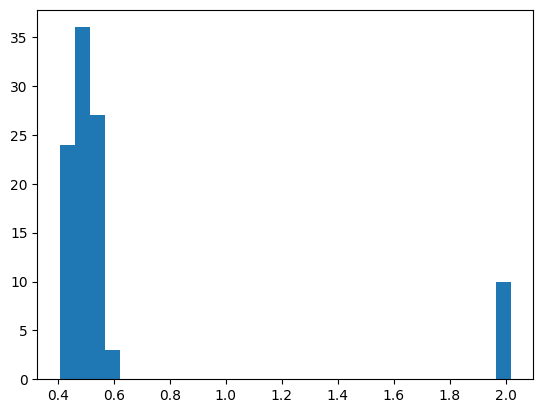

In [49]:
plt.hist(dist_mean_arr_check, bins=30)

(array([ 5.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        27., 36., 18.,  8.]),
 array([-2.95248708e+01, -2.84699603e+01, -2.74150499e+01, -2.63601394e+01,
        -2.53052290e+01, -2.42503185e+01, -2.31954081e+01, -2.21404976e+01,
        -2.10855872e+01, -2.00306768e+01, -1.89757663e+01, -1.79208559e+01,
        -1.68659454e+01, -1.58110350e+01, -1.47561245e+01, -1.37012141e+01,
        -1.26463037e+01, -1.15913932e+01, -1.05364828e+01, -9.48157232e+00,
        -8.42666188e+00, -7.37175144e+00, -6.31684099e+00, -5.26193055e+00,
        -4.20702011e+00, -3.15210966e+00, -2.09719922e+00, -1.04228878e+00,
         1.26216666e-02,  1.06753211e+00,  2.12244255e+00]),
 <BarContainer object of 30 artists>)

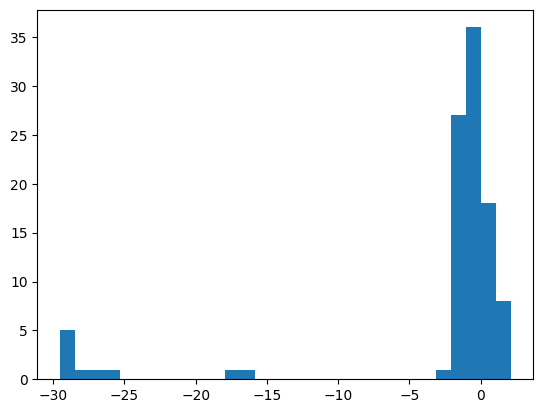

In [50]:
plt.hist(Pk_ratio_sum, bins=30)

In [51]:
i_bad_Pk = Pk_ratio_sum < -8
i_check_bad_pk = i_check[i_bad_Pk]
print(idxs_LH_check[i_check_bad_pk])
i_bad_field = np.array(dist_mean_arr_check) > 1
i_check_bad_field = i_check[i_bad_field]
print(idxs_LH_check[i_check_bad_field])

[3919 3921 3938 3987 3995 4010 4036 4037 4122 4125]
[3919 3921 3938 3987 3995 4010 4036 4037 4122 4125]


-1.2964927 19.363144
-1.2964927 19.363144
(128, 128, 128)
(128, 128)


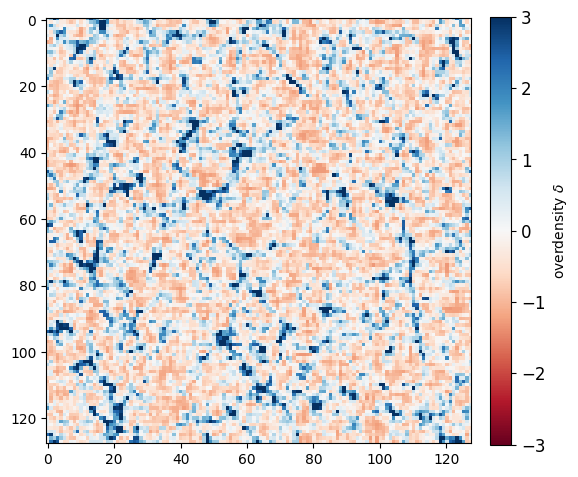

In [52]:
plotter.plot_field(pos_arr_check[i_check_bad_pk[0]])

-3.8858821 5.208785
-3.8858821 5.208785
(128, 128, 128)
(128, 128)


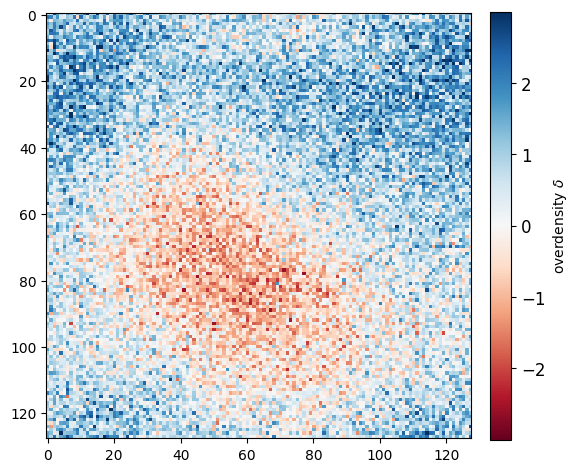

In [53]:
plotter.plot_field(bias0_arr_check[i_check_bad_pk[0]])

-3.63425 5.0142226
-3.63425 5.0142226
(128, 128, 128)
(128, 128)


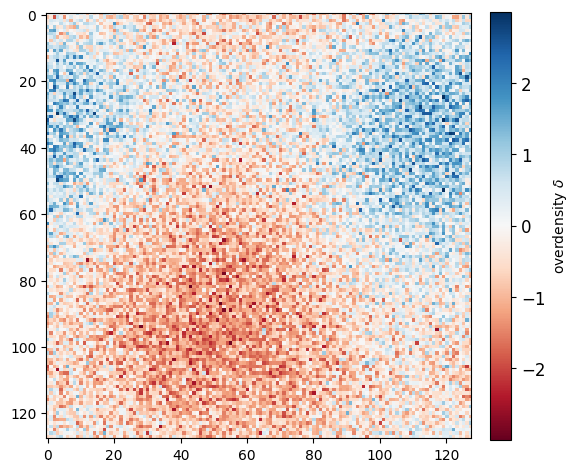

In [72]:
plotter.plot_field(bias0_arr_check[i_check_bad_pk[1]])

-3.8668132 5.050618
-3.8668132 5.050618
(128, 128, 128)
(128, 128)


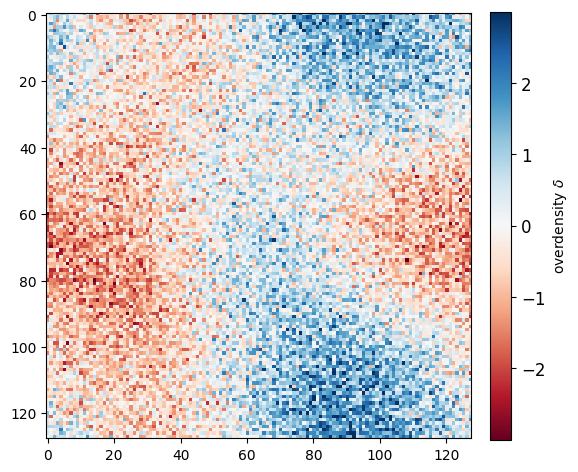

In [75]:
plotter.plot_field(bias0_arr_check[i_check_bad_pk[-1]])

-8.490085 62.9702
-8.490085 62.9702
(128, 128, 128)
(128, 128)


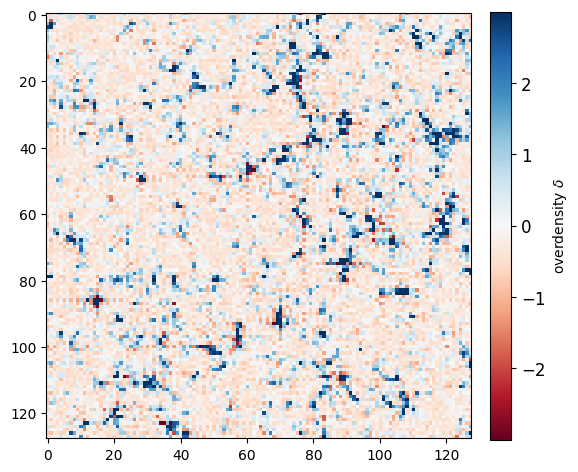

In [74]:
plotter.plot_field(bias0_arr_check[i_check[-1]])

In [ ]:
np.allclose(disp_field, disp_field_taufix)

True